In [55]:
# setup_project.py
import os
from pathlib import Path

def create_project_structure():
    structure = [
        "config/",
        "data/raw/",
        "data/processed/",
        "data/external/",
        "data/interim/",
        "src/data/",
        "src/features/",
        "src/models/",
        "src/visualization/",
        "src/utils/",
        "notebooks/",
        "scripts/",
        "tests/",
        "outputs/figures/",
        "outputs/tables/",
        "outputs/models/",
        "outputs/reports/",
        "docs/api/",
        ".github/workflows/"
    ]
    
    for dir_path in structure:
        Path(dir_path).mkdir(parents=True, exist_ok=True)
        # 创建__init__.py文件（Python包）
        if dir_path.startswith("src/") or dir_path.startswith("tests/"):
            init_file = os.path.join(dir_path, "__init__.py")
            if not os.path.exists(init_file):
                with open(init_file, "w") as f:
                    pass
    
    # 创建核心配置文件
    config_files = [
        ("config/config.yaml", ""),
        ("config/data_config.json", "{}"),
        ("config/model_params.yaml", ""),
        ("requirements.txt", ""),
        ("environment.yml", ""),
        ("setup.py", ""),
        ("README.md", "# 粤港澳大湾区数据要素流动多元统计分析实验")
    ]
    
    for file_path, content in config_files:
        if not os.path.exists(file_path):
            with open(file_path, "w") as f:
                f.write(content)

if __name__ == "__main__":
    create_project_structure()
    print("项目结构初始化完成")

项目结构初始化完成


In [56]:
# src/data/preprocessor.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class DataPreprocessor:
    """数据预处理类，处理缺失值、异常值和数据变换"""
    
    def __init__(self, data: pd.DataFrame):
        """
        初始化预处理类
        
        参数:
            data: 原始数据DataFrame
        """
        self.data = data.copy()
        self.missing_report = None
        self.outlier_report = None
        self.numeric_cols = self.data.select_dtypes(include=[np.number]).columns.tolist()
        self.non_numeric_cols = self.data.select_dtypes(exclude=[np.number]).columns.tolist()
        
    def missing_value_analysis(self) -> pd.DataFrame:
        """分析缺失值情况"""
        missing_count = self.data.isnull().sum()
        missing_percent = (missing_count / len(self.data)) * 100
        self.missing_report = pd.DataFrame({
            '缺失值数量': missing_count,
            '缺失比例(%)': missing_percent
        }).sort_values('缺失比例(%)', ascending=False)
        return self.missing_report
    
    def handle_missing_values(self, method: str = 'mice', 
                             visualize: bool = True) -> Tuple[pd.DataFrame, dict]:
        """
        处理缺失值
        
        参数:
            method: 缺失值处理方法
            visualize: 是否可视化处理效果
            
        返回:
            处理后的数据和评估指标
        """
        import os
        os.makedirs('outputs/figures', exist_ok=True)
        
        numeric_data = self.data[self.numeric_cols].copy()
        non_numeric_data = self.data[self.non_numeric_cols].copy()
        
        methods = {
            'mean': lambda: numeric_data.fillna(numeric_data.mean()),
            'median': lambda: numeric_data.fillna(numeric_data.median()),
            'knn': lambda: pd.DataFrame(
                KNNImputer(n_neighbors=5).fit_transform(numeric_data),
                columns=numeric_data.columns, index=numeric_data.index
            ),
            'mice': lambda: pd.DataFrame(
                IterativeImputer(random_state=42).fit_transform(numeric_data),
                columns=numeric_data.columns, index=numeric_data.index
            ),
            'time': lambda: numeric_data.interpolate(method='time')
        }
        
        if method not in methods:
            raise ValueError(f"不支持的方法: {method}，支持的方法有: {list(methods.keys())}")
            
        # 保存原始数据中无缺失的部分用于评估
        non_missing_mask = ~numeric_data.isnull()
        original_values = numeric_data.values[non_missing_mask]
        
        # 执行插补
        imputed_numeric_data = methods[method]()
        
        # 计算评估指标
        metrics = {}
        if len(original_values) > 0:
            imputed_values = imputed_numeric_data.values[non_missing_mask]
            metrics = {
                'RMSE': np.sqrt(np.mean((original_values - imputed_values) **2)),
                'MAE': np.mean(np.abs(original_values - imputed_values))
            }
            
            # 额外：评估缺失值插补的合理性（可选）
            missing_mask = numeric_data.isnull()
            if missing_mask.any().any():
                missing_values_count = missing_mask.sum().sum()
                metrics['missing_values_imputed'] = missing_values_count
        
        else:
            metrics = {'RMSE': 0, 'MAE': 0}
        
        # 可视化
        if visualize and len(original_values) > 0:
            plt.figure(figsize=(10, 6))
            plt.scatter(original_values, imputed_values, alpha=0.5)
            plt.plot([original_values.min(), original_values.max()],
                    [original_values.min(), original_values.max()], 'r--')
            plt.xlabel('Original Values')
            plt.ylabel(f'{method} Imputed Values')
            plt.title(f'Imputation Comparison (RMSE: {metrics["RMSE"]:.4f})')
            plt.tight_layout()
            plt.savefig(f'outputs/figures/missing_imputation_{method}.png')
            plt.close()
        
        # 合并数据
        imputed_data = pd.concat([imputed_numeric_data, non_numeric_data], axis=1)
        imputed_data = imputed_data[self.data.columns]
        
        return imputed_data, metrics
    
    def detect_outliers(self, method: str = 'isolation_forest', 
                       threshold: float = 0.05) -> Tuple[pd.DataFrame, dict]:
        """
        检测异常值
        
        参数:
            method: 异常值检测方法
            threshold: 异常值比例阈值
            
        返回:
            标记异常值的数据和异常值报告
        """
        numeric_data = self.data[self.numeric_cols].copy()
        outlier_mask = pd.DataFrame(False, index=self.data.index, columns=self.data.columns)
        outlier_count = {}
        
        for col in numeric_data.columns:
            full_data = numeric_data[col].copy()
            valid_idx = full_data.dropna().index
            valid_data = full_data.loc[valid_idx].values.reshape(-1, 1)
            
            if len(valid_data) == 0:
                outlier_count[col] = 0
                continue
                
            # 正确计算异常值数量（四舍五入）
            n_outliers = int(round(len(valid_data) * threshold))
            # 确保至少有1个异常值（如果数据量足够）
            n_outliers = max(1, n_outliers) if len(valid_data) >= 20 else 0
            
            temp_outliers = np.zeros(len(valid_data), dtype=bool)
            
            if method == 'grubbs':
                outliers = []
                temp_data = valid_data.copy().flatten()
                while len(outliers) < n_outliers and len(temp_data) > 2:
                    try:
                        stat, p = stats.grubbs(temp_data)
                        if p < 0.05:
                            mean_val = np.mean(temp_data)
                            idx = np.argmax(np.abs(temp_data - mean_val))
                            outliers.append(temp_data[idx])
                            temp_outliers[idx] = True
                            temp_data = np.delete(temp_data, idx)
                        else:
                            break
                    except:
                        break
                
            elif method == 'isolation_forest':
                # 使用更稳健的参数
                clf = IsolationForest(
                    contamination=threshold, 
                    random_state=42,
                    n_estimators=100,
                    max_samples='auto'
                )
                preds = clf.fit_predict(valid_data)
                temp_outliers = preds == -1
                
            elif method == 'lof':
                clf = LocalOutlierFactor(
                    n_neighbors=max(5, min(20, len(valid_data)//5)),
                    contamination=threshold
                )
                preds = clf.fit_predict(valid_data)
                temp_outliers = preds == -1
                
            elif method == 'stl':
                if pd.api.types.is_datetime64_any_dtype(self.data.index):
                    if len(valid_data) >= 12:
                        try:
                            res = seasonal_decompose(
                                valid_data.flatten(), model='additive', period=12, extrapolate_trend='freq')
                            residuals = res.resid
                            valid_residuals = residuals[~np.isnan(residuals)]
                            if len(valid_residuals) > 0:
                                z_scores = np.abs(stats.zscore(valid_residuals))
                                threshold_z = np.percentile(z_scores, 100*(1-threshold))
                                z_scores_full = np.full(len(valid_data), np.nan)
                                z_scores_full[~np.isnan(residuals)] = np.abs(stats.zscore(valid_residuals))
                                temp_outliers = z_scores_full > threshold_z
                        except:
                            z_scores = np.abs(stats.zscore(valid_data.flatten()))
                            threshold_z = np.percentile(z_scores, 100*(1-threshold))
                            temp_outliers = z_scores > threshold_z
                    else:
                        z_scores = np.abs(stats.zscore(valid_data.flatten()))
                        threshold_z = np.percentile(z_scores, 100*(1-threshold))
                        temp_outliers = z_scores > threshold_z
                else:
                    raise ValueError("STL分解需要时间序列索引")
            else:
                raise ValueError(f"不支持的方法: {method}，支持的方法有: grubbs, isolation_forest, lof, stl")
            
            # 映射回原始索引
            outlier_mask.loc[valid_idx, col] = temp_outliers
            # 统计实际检测到的异常值数量
            outlier_count[col] = temp_outliers.sum()
        
        # 非数值列
        for col in self.non_numeric_cols:
            outlier_count[col] = 0
            outlier_mask[col] = False
        
        self.outlier_report = pd.Series(outlier_count, name='异常值数量').sort_values(ascending=False)
        return outlier_mask, self.outlier_report
    
    def handle_outliers(self, outlier_mask: pd.DataFrame, method: str = 'cap') -> pd.DataFrame:
        """处理异常值"""
        processed_data = self.data.copy()
        numeric_cols = self.numeric_cols
        
        for col in numeric_cols:
            if col in outlier_mask.columns:
                outliers = outlier_mask[col]
                if outliers.sum() == 0:
                    continue
                    
                data_col = processed_data[col]
                non_outliers = data_col[~outliers]
                
                if method == 'cap':
                    q01 = non_outliers.quantile(0.01)
                    q99 = non_outliers.quantile(0.99)
                    processed_data.loc[outliers & (data_col < q01), col] = q01
                    processed_data.loc[outliers & (data_col > q99), col] = q99
                    
                elif method == 'remove':
                    processed_data = processed_data[~outliers]
                    
                elif method == 'replace':
                    median_val = non_outliers.median()
                    processed_data.loc[outliers, col] = median_val
                    
                elif method == 'nan':
                    processed_data.loc[outliers, col] = np.nan
                    
                else:
                    raise ValueError(f"不支持的处理方法: {method}")
        
        return processed_data
    
    def transform_data(self, method: str = 'standardize', 
                      visualize: bool = True) -> pd.DataFrame:
        """数据变换"""
        import os
        os.makedirs('outputs/figures', exist_ok=True)
        
        numeric_data = self.data[self.numeric_cols].copy()
        non_numeric_data = self.data[self.non_numeric_cols].copy()
        transformed_data = numeric_data.copy()
        
        for col in numeric_data.columns:
            data = numeric_data[col].dropna()
            if len(data) == 0:
                continue
            
            if method == 'standardize':
                transformed = (data - data.mean()) / data.std()
            elif method == 'normalize':
                transformed = (data - data.min()) / (data.max() - data.min())
            elif method == 'log':
                min_val = data.min()
                if min_val <= 0:
                    transformed = np.log1p(data - min_val + 1e-6)
                else:
                    transformed = np.log1p(data)
            elif method == 'boxcox':
                min_val = data.min()
                if min_val <= 0:
                    data_pos = data - min_val + 1e-6
                else:
                    data_pos = data
                transformed, _ = stats.boxcox(data_pos)
            elif method == 'yeojohnson':
                transformed, _ = stats.yeojohnson(data)
            else:
                raise ValueError(f"不支持的变换方法: {method}")
                
            transformed_data.loc[data.index, col] = transformed
        
        # 可视化
        if visualize and len(numeric_data.columns) > 0:
            n_cols = 3
            n_rows = (len(numeric_data.columns) + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
            axes = axes.flatten()
            
            for i, col in enumerate(numeric_data.columns):
                if i < len(axes):
                    ax1 = axes[i]
                    sns.histplot(numeric_data[col].dropna(), kde=True, ax=ax1, color='blue', label='Original', alpha=0.5)
                    sns.histplot(transformed_data[col].dropna(), kde=True, ax=ax1, color='red', label='Transformed', alpha=0.5)
                    ax1.set_title(f'{col} - Original vs Transformed')
                    ax1.set_xlabel('Value')
                    ax1.set_ylabel('Frequency')
                    ax1.legend()
            
            for i in range(len(numeric_data.columns), len(axes)):
                axes[i].set_visible(False)
            
            plt.tight_layout()
            plt.savefig(f'outputs/figures/data_transform_{method}.png')
            plt.close()
            
        result = pd.concat([transformed_data, non_numeric_data], axis=1)
        result = result[self.data.columns]
        return result
    
    def check_multicollinearity(self, threshold: float = 10.0) -> pd.DataFrame:
        """检查多重共线性"""
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        
        import os
        os.makedirs('outputs/figures', exist_ok=True)
        
        numeric_data = self.data[self.numeric_cols].copy().dropna()
        numeric_data = numeric_data.loc[:, numeric_data.var() > 1e-10]
        
        if numeric_data.empty or len(numeric_data.columns) < 2:
            return pd.DataFrame({'特征': [], 'VIF值': [], '是否需要处理': []})
        
        vif_data = pd.DataFrame()
        vif_data["Feature"] = numeric_data.columns
        vif_data["VIF Value"] = [variance_inflation_factor(
            numeric_data.values, i) for i in range(numeric_data.shape[1])]
        
        vif_data = vif_data.sort_values("VIF Value", ascending=False)
        vif_data["Need Handling"] = vif_data["VIF Value"] > threshold
        
        # 可视化
        high_vif = vif_data[vif_data["VIF Value"] > threshold]
        if not high_vif.empty:
            plt.figure(figsize=(10, 6))
            sns.barplot(x="VIF Value", y="Feature", data=high_vif)
            plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')
            plt.title('High VIF Features (Multicollinearity)')
            plt.xlabel('Variance Inflation Factor (VIF)')
            plt.ylabel('Feature')
            plt.legend()
            plt.tight_layout()
            plt.savefig('outputs/figures/high_vif_features.png')
            plt.close()
            
        vif_data_cn = vif_data.copy()
        vif_data_cn.columns = ['特征', 'VIF值', '是否需要处理']
        return vif_data_cn
    
    def get_preprocessing_report(self) -> str:
        """生成预处理报告"""
        report = []
        report.append("="*50)
        report.append("Data Preprocessing Report")
        report.append("="*50)
        
        report.append(f"\n1. Basic Information:")
        report.append(f"   - Data shape: {self.data.shape}")
        report.append(f"   - Numeric columns: {len(self.numeric_cols)} ({', '.join(self.numeric_cols)})")
        report.append(f"   - Non-numeric columns: {len(self.non_numeric_cols)} ({', '.join(self.non_numeric_cols)})")
        
        if self.missing_report is not None:
            report.append(f"\n2. Missing Values Statistics:")
            total_missing = self.missing_report['缺失值数量'].sum()
            report.append(f"   - Total missing values: {total_missing}")
            report.append(f"   - Missing value ratio: {total_missing/(self.data.shape[0]*self.data.shape[1])*100:.2f}%")
            if total_missing > 0:
                report.append(f"   - Column with most missing values: {self.missing_report.index[0]} ({self.missing_report['缺失比例(%)'].iloc[0]:.2f}%)")
        
        if self.outlier_report is not None:
            report.append(f"\n3. Outliers Statistics:")
            total_outliers = self.outlier_report.sum()
            report.append(f"   - Total outliers: {total_outliers}")
            numeric_cells = self.data[self.numeric_cols].size
            if numeric_cells > 0:
                report.append(f"   - Outlier ratio: {total_outliers/numeric_cells*100:.2f}%")
            if total_outliers > 0:
                report.append(f"   - Column with most outliers: {self.outlier_report.index[0]} ({self.outlier_report.iloc[0]} items)")
        
        report.append("\n" + "="*50)
        
        return "\n".join(report)


# 使用示例
if __name__ == "__main__":
    # 创建示例数据
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', periods=100)
    data = pd.DataFrame({
        'value1': np.random.normal(100, 10, 100) + np.linspace(0, 5, 100),
        'value2': np.random.normal(50, 5, 100),
        'value3': np.random.poisson(20, 100),
        'category': np.random.choice(['A', 'B', 'C'], 100)
    }, index=dates)
    
    # 添加缺失值
    np.random.seed(42)
    missing_idx1 = data.sample(frac=0.1, random_state=42).index
    data.loc[missing_idx1, 'value1'] = np.nan
    
    np.random.seed(43)
    missing_idx2 = data.sample(frac=0.05, random_state=43).index
    data.loc[missing_idx2, 'value2'] = np.nan
    
    # 添加异常值
    np.random.seed(44)
    outliers_idx = data.dropna(subset=['value1']).sample(frac=0.03, random_state=44).index
    data.loc[outliers_idx, 'value1'] = data.loc[outliers_idx, 'value1'] * 3
    
    # 初始化预处理器
    preprocessor = DataPreprocessor(data)
    
    # 1. 缺失值分析
    missing_report = preprocessor.missing_value_analysis()
    print("Missing Values Report:")
    print(missing_report)
    
    # 2. 处理缺失值
    imputed_data, metrics = preprocessor.handle_missing_values(method='mice')
    print(f"\nMissing Value Handling Metrics: {metrics}")
    
    # 3. 检测异常值
    outlier_mask, outlier_report = preprocessor.detect_outliers(method='isolation_forest', threshold=0.05)
    print("\nOutliers Report:")
    print(outlier_report)
    
    # 4. 处理异常值
    cleaned_data = preprocessor.handle_outliers(outlier_mask, method='cap')
    
    # 5. 数据变换
    transformed_data = preprocessor.transform_data(method='standardize')
    
    # 6. 检查多重共线性
    vif_report = preprocessor.check_multicollinearity()
    print("\nVIF Report:")
    print(vif_report)
    
    # 7. 生成预处理报告
    print("\n" + preprocessor.get_preprocessing_report())

Missing Values Report:
          缺失值数量  缺失比例(%)
value1       10     10.0
value2        5      5.0
value3        0      0.0
category      0      0.0

Missing Value Handling Metrics: {'RMSE': 0.0, 'MAE': 0.0, 'missing_values_imputed': 15}

Outliers Report:
value1      5
value2      5
value3      5
category    0
Name: 异常值数量, dtype: int64

VIF Report:
       特征       VIF值  是否需要处理
1  value2  22.367000    True
2  value3  15.307862    True
0  value1   7.300436   False

Data Preprocessing Report

1. Basic Information:
   - Data shape: (100, 4)
   - Numeric columns: 3 (value1, value2, value3)
   - Non-numeric columns: 1 (category)

2. Missing Values Statistics:
   - Total missing values: 15
   - Missing value ratio: 3.75%
   - Column with most missing values: value1 (10.00%)

3. Outliers Statistics:
   - Total outliers: 15
   - Outlier ratio: 5.00%
   - Column with most outliers: value1 (5 items)



In [57]:
# src/visualization/plot_utils.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from typing import Optional, List, Dict
import warnings
warnings.filterwarnings('ignore')

# ========== 修复中文字体配置 ==========
def setup_chinese_font():
    """适配不同操作系统的中文字体设置"""
    import platform
    system = platform.system()
    
    # 定义各系统的中文字体列表（优先级从高到低）
    font_configs = {
        'Windows': ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS'],
        'Darwin': ['Heiti TC', 'PingFang SC', 'Songti SC', 'Arial Unicode MS'],  # macOS
        'Linux': ['WenQuanYi Micro Hei', 'Noto Sans CJK SC', 'DejaVu Sans']      # Linux
    }
    
    # 获取当前系统的字体列表
    available_fonts = font_configs.get(system, ['DejaVu Sans', 'Arial'])
    
    # 测试并设置字体
    for font in available_fonts:
        try:
            plt.rcParams["font.family"] = font
            # 测试字体是否可用
            fig, ax = plt.subplots(figsize=(1, 1))
            ax.text(0.5, 0.5, '测试中文', fontsize=10)
            plt.close(fig)
            print(f"成功设置字体: {font}")
            break
        except:
            continue
    else:
        # 如果所有中文字体都不可用，使用默认字体并禁用中文显示警告
        plt.rcParams["font.family"] = 'DejaVu Sans'
        print("警告：未找到中文字体，图表可能无法正常显示中文")
    
    # 解决负号显示问题
    plt.rcParams["axes.unicode_minus"] = False

# 执行字体设置
setup_chinese_font()

# ========== 其余代码保持不变 ==========
# 尝试导入geopandas，如果失败则标记为不可用
try:
    import geopandas as gpd
    GEOPANDAS_AVAILABLE = True
except ImportError:
    GEOPANDAS_AVAILABLE = False
    # 创建一个占位的GeoDataFrame类，用于类型提示
    class gpd:
        class GeoDataFrame:
            pass

class EDAVisualizer:
    """探索性数据分析可视化工具类"""
    
    def __init__(self, figsize: tuple = (12, 8)):
        """初始化可视化工具"""
        self.figsize = figsize
        # 确保输出目录存在
        import os
        os.makedirs('outputs/figures', exist_ok=True)
        
    def plot_time_trends(self, data: pd.DataFrame, 
                        time_col: str = '年份',
                        variables: List[str] = None,
                        title: str = '时间趋势分析'):
        """
        绘制时间趋势图
        
        参数:
            data: 包含时间序列的数据框
            time_col: 时间列名称
            variables: 需要绘制的变量列表
            title: 图表标题
        """
        if variables is None:
            variables = [col for col in data.columns if col != time_col]
            
        # 过滤掉非数值列
        variables = [var for var in variables if pd.api.types.is_numeric_dtype(data[var])]
        
        plt.figure(figsize=self.figsize)
        
        for var in variables:
            # 处理缺失值
            plot_data = data[[time_col, var]].dropna()
            if len(plot_data) > 0:
                plt.plot(plot_data[time_col], plot_data[var], marker='o', label=var, alpha=0.8)
            
        plt.title(title, fontsize=15)
        plt.xlabel(time_col, fontsize=12)
        plt.ylabel('数值', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        
        # 保存图片，处理标题中的特殊字符
        safe_title = title.replace(" ", "_").replace("/", "_").replace("\\", "_")
        plt.savefig(f'outputs/figures/time_trends_{safe_title}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def plot_distributions(self, data: pd.DataFrame, 
                          variables: List[str] = None,
                          title: str = '变量分布分析'):
        """
        绘制变量分布图
        
        参数:
            data: 数据框
            variables: 需要绘制的变量列表
            title: 图表标题
        """
        if variables is None:
            variables = data.select_dtypes(include=[np.number]).columns.tolist()
        
        # 过滤掉空列或常量列
        variables = [var for var in variables if data[var].nunique() > 1 and not data[var].isnull().all()]
        
        n = len(variables)
        if n == 0:
            print("警告：没有可绘制的数值变量")
            return
        
        n_rows = (n + 1) // 2
        n_cols = min(2, n)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        axes = axes.flatten() if n > 1 else [axes]
        
        for i, var in enumerate(variables):
            if i < len(axes):
                # 绘制分布
                sns.histplot(data[var].dropna(), kde=True, ax=axes[i], alpha=0.7)
                axes[i].set_title(f'{var}的分布')
                axes[i].grid(alpha=0.3)
            
        # 移除多余的子图
        for i in range(n, len(axes)):
            fig.delaxes(axes[i])
            
        plt.suptitle(title, fontsize=15, y=1.02)
        plt.tight_layout()
        
        # 保存图片
        safe_title = title.replace(" ", "_").replace("/", "_").replace("\\", "_")
        plt.savefig(f'outputs/figures/distributions_{safe_title}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def plot_correlation_matrix(self, data: pd.DataFrame, 
                               method: str = 'pearson',
                               title: str = '相关性矩阵'):
        """
        绘制相关性矩阵热图
        
        参数:
            data: 数据框
            method: 相关性计算方法 ('pearson', 'spearman', 'kendall')
            title: 图表标题
            
        返回:
            相关性矩阵
        """
        # 选择数值列并去除缺失值过多的列
        numeric_data = data.select_dtypes(include=[np.number])
        numeric_data = numeric_data.dropna(thresh=len(numeric_data)*0.1, axis=1)
        
        if numeric_data.shape[1] < 2:
            print("警告：数值列数量不足，无法计算相关性矩阵")
            return pd.DataFrame()
        
        # 计算相关性矩阵
        corr_matrix = numeric_data.corr(method=method)
        
        plt.figure(figsize=self.figsize)
        # 创建上三角掩码
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        # 自定义颜色映射
        cmap = LinearSegmentedColormap.from_list(
            'custom', ['#3791D7', '#FFFFFF', '#E42C2C'], N=256)
        
        # 绘制热图
        sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
                  square=True, linewidths=.5, annot=True, fmt=".2f",
                  cbar_kws={"shrink": .8})
        
        plt.title(title, fontsize=15)
        plt.tight_layout()
        
        # 保存图片
        plt.savefig(f'outputs/figures/correlation_matrix_{method}.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        return corr_matrix
    
    def plot_spatial_distribution(self, gdf: gpd.GeoDataFrame, 
                                 value_col: str,
                                 title: str = '空间分布'):
        """
        绘制空间分布图
        
        参数:
            gdf: GeoDataFrame对象
            value_col: 用于着色的数值列
            title: 图表标题
        """
        if not GEOPANDAS_AVAILABLE:
            print("错误：需要安装geopandas才能使用空间分布绘图功能")
            print("请运行：pip install geopandas")
            return
        
        if not isinstance(gdf, gpd.GeoDataFrame):
            print("错误：输入数据必须是GeoDataFrame类型")
            return
        
        if value_col not in gdf.columns:
            print(f"错误：列 {value_col} 不存在于数据中")
            return
        
        # 过滤掉缺失值
        plot_gdf = gdf.dropna(subset=[value_col])
        if len(plot_gdf) == 0:
            print("警告：没有可用的空间数据（缺失值过多）")
            return
        
        plt.figure(figsize=self.figsize)
        
        # 绘制基础地图
        gdf.plot(edgecolor='white', linewidth=0.5, color='lightgray', ax=plt.gca())
        
        # 绘制值分布
        plot_gdf.plot(column=value_col, cmap='YlOrRd', legend=True, ax=plt.gca(),
                legend_kwds={'label': f'{value_col}', 'orientation': 'horizontal', 'shrink': 0.8})
        
        plt.title(title, fontsize=15)
        plt.axis('off')
        plt.tight_layout()
        
        # 保存图片
        safe_col = value_col.replace(" ", "_").replace("/", "_").replace("\\", "_")
        plt.savefig(f'outputs/figures/spatial_distribution_{safe_col}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def plot_inequality_measures(self, data: pd.DataFrame, 
                                city_col: str,
                                value_col: str,
                                year_col: str = None,
                                title: str = '不平等程度分析'):
        """
        绘制基尼系数、洛伦兹曲线等不平等指标
        
        参数:
            data: 数据框
            city_col: 城市/地区列名称
            value_col: 用于计算不平等的数值列
            year_col: 年份列名称（可选）
            title: 图表标题
        """
        def gini_coefficient(x):
            """计算基尼系数"""
            x = np.array(x)
            x = x[~np.isnan(x)]  # 去除NaN值
            if len(x) < 2 or np.sum(x) == 0:
                return np.nan
            
            x = np.sort(x)
            n = len(x)
            return (2 * np.sum(np.arange(1, n+1) * x)) / (n * np.sum(x)) - (n + 1) / n
        
        # 过滤有效数据
        valid_data = data[[col for col in [city_col, value_col, year_col] if col is not None]].dropna()
        if len(valid_data) == 0:
            print("警告：没有足够的有效数据计算不平等指标")
            return
        
        # 计算基尼系数
        if year_col and year_col in valid_data.columns:
            results = {}
            for year in sorted(valid_data[year_col].unique()):
                year_data = valid_data[valid_data[year_col] == year][value_col]
                gini = gini_coefficient(year_data)
                if not np.isnan(gini):
                    results[year] = gini
            
            if results:
                # 绘制基尼系数时间变化
                plt.figure(figsize=(10, 6))
                plt.plot(list(results.keys()), list(results.values()), marker='o', linewidth=2, markersize=8)
                plt.title(f'{title} - 基尼系数时间变化', fontsize=15)
                plt.xlabel('年份', fontsize=12)
                plt.ylabel('基尼系数', fontsize=12)
                plt.grid(alpha=0.3)
                plt.ylim(0, 1)
                
                # 添加数值标签
                for year, gini in results.items():
                    plt.text(year, gini + 0.01, f'{gini:.3f}', ha='center')
                
                plt.tight_layout()
                safe_col = value_col.replace(" ", "_")
                plt.savefig(f'outputs/figures/gini_trend_{safe_col}.png', dpi=300, bbox_inches='tight')
                plt.close()
                
                # 选择最新年份绘制洛伦兹曲线
                latest_year = max(results.keys())
                values = valid_data[valid_data[year_col] == latest_year][value_col].dropna().sort_values()
                print(f'{latest_year}年基尼系数: {results[latest_year]:.4f}')
            else:
                print("警告：无法计算有效年份的基尼系数")
                return
        else:
            # 不按年份分组
            values = valid_data[value_col].dropna().sort_values()
            gini = gini_coefficient(values)
            if not np.isnan(gini):
                print(f'基尼系数: {gini:.4f}')
            else:
                print("警告：无法计算基尼系数")
                return
        
        # 绘制洛伦兹曲线
        values = values.values
        n = len(values)
        if n < 2:
            print("警告：数据点不足，无法绘制洛伦兹曲线")
            return
        
        cumulative_pop = np.arange(1, n+1) / n
        cumulative_income = np.cumsum(values) / np.sum(values)
        
        plt.figure(figsize=(8, 8))
        plt.plot(cumulative_pop, cumulative_income, label='洛伦兹曲线', linewidth=2, color='#2E86AB')
        plt.plot([0, 1], [0, 1], 'r--', label='绝对平等线', linewidth=2)
        plt.fill_between(cumulative_pop, cumulative_pop, cumulative_income, alpha=0.2, color='#A23B72')
        
        plt.title(f'{title} - 洛伦兹曲线', fontsize=15)
        plt.xlabel('累积人口比例', fontsize=12)
        plt.ylabel('累积值比例', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.3)
        plt.axis('equal')  # 保证x和y轴比例一致
        
        plt.tight_layout()
        safe_col = value_col.replace(" ", "_")
        plt.savefig(f'outputs/figures/lorenz_curve_{safe_col}.png', dpi=300, bbox_inches='tight')
        plt.close()

# 使用示例
if __name__ == "__main__":
    # 创建示例数据
    np.random.seed(42)
    
    # 时间序列数据
    years = list(range(2010, 2023))
    n_years = len(years)
    time_data = pd.DataFrame({
        '年份': years * 3,
        '地区': ['北京']*n_years + ['上海']*n_years + ['广州']*n_years,
        'GDP': np.random.normal(20000, 5000, n_years*3).cumsum() + 100000,
        '人口': np.random.normal(2000, 500, n_years*3).cumsum() + 10000,
        '人均收入': np.random.normal(50000, 10000, n_years*3).cumsum()
    })
    
    # 横截面数据
    city_data = pd.DataFrame({
        '城市': [f'城市{i}' for i in range(1, 101)],
        '人均GDP': np.random.lognormal(10, 0.8, 100),
        '人均收入': np.random.lognormal(9, 0.9, 100),
        '失业率': np.random.uniform(2, 8, 100),
        '人口密度': np.random.lognormal(8, 1.2, 100)
    })
    
    # 初始化可视化工具
    visualizer = EDAVisualizer(figsize=(12, 8))
    
    # 1. 绘制时间趋势图
    beijing_data = time_data[time_data['地区'] == '北京']
    visualizer.plot_time_trends(beijing_data, time_col='年份', 
                               variables=['GDP', '人口', '人均收入'],
                               title='北京经济指标时间趋势')
    
    # 2. 绘制变量分布图
    visualizer.plot_distributions(city_data, variables=['人均GDP', '人均收入', '失业率'],
                                 title='城市经济指标分布')
    
    # 3. 绘制相关性矩阵
    corr_matrix = visualizer.plot_correlation_matrix(city_data, method='pearson')
    print("\n相关性矩阵:")
    print(corr_matrix.round(2))
    
    # 4. 绘制不平等指标
    visualizer.plot_inequality_measures(city_data, city_col='城市', 
                                       value_col='人均收入',
                                       title='城市收入不平等分析')
    
    # 5. 测试时间序列的不平等分析
    inequality_data = pd.DataFrame({
        '城市': [f'城市{i}' for i in range(1, 101)] * 3,
        '年份': [2020]*100 + [2021]*100 + [2022]*100,
        '人均可支配收入': np.random.lognormal(10, np.random.uniform(0.7, 1.0), 300)
    })
    visualizer.plot_inequality_measures(inequality_data, city_col='城市',
                                       value_col='人均可支配收入',
                                       year_col='年份',
                                       title='城市收入不平等时间变化')
    
    # 6. 测试空间分布功能（如果有geopandas）
    if GEOPANDAS_AVAILABLE:
        try:
            # 创建示例空间数据
            from shapely.geometry import Point
            geometries = [Point(np.random.uniform(110, 120), np.random.uniform(30, 40)) for _ in range(100)]
            gdf = gpd.GeoDataFrame(city_data, geometry=geometries)
            visualizer.plot_spatial_distribution(gdf, value_col='人均GDP',
                                                title='城市人均GDP空间分布')
        except Exception as e:
            print(f"空间分布图绘制失败: {e}")
    else:
        print("\n提示：安装geopandas以使用空间分布可视化功能")
        print("安装命令: pip install geopandas")
    
    print("\n所有图表已保存到 outputs/figures/ 目录")

成功设置字体: SimHei

相关性矩阵:
       人均GDP  人均收入   失业率  人口密度
人均GDP   1.00 -0.05  0.09 -0.07
人均收入   -0.05  1.00  0.12 -0.06
失业率     0.09  0.12  1.00 -0.05
人口密度   -0.07 -0.06 -0.05  1.00
基尼系数: 0.4633
2022年基尼系数: 0.4038

所有图表已保存到 outputs/figures/ 目录


In [10]:
 !pip install geopandas

In [58]:


# src/models/pca_analyzer.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy.stats import bartlett, kstest
from scipy.linalg import svd
from typing import Tuple, List, Dict
import os
import platform

# 修复中文字体配置（跨平台适配）
def setup_chinese_font():
    """适配不同操作系统的中文字体"""
    system = platform.system()
    plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题
    
    if system == "Windows":
        # Windows系统字体
        font_list = ["SimHei", "Microsoft YaHei", "SimSun", "FangSong"]
    elif system == "Darwin":  # macOS
        font_list = ["PingFang SC", "Heiti TC", "Arial Unicode MS"]
    else:  # Linux
        font_list = ["WenQuanYi Micro Hei", "DejaVu Sans"]
    
    # 测试可用字体
    for font in font_list:
        try:
            plt.rcParams["font.family"] = font
            # 测试字体是否可用
            fig = plt.figure()
            plt.text(0.5, 0.5, "测试中文", fontsize=12)
            plt.close(fig)
            break
        except:
            continue
    else:
        # 如果都不可用，使用默认字体
        plt.rcParams["font.family"] = "sans-serif"

# 初始化字体配置
setup_chinese_font()

class PCAAnalyzer:
    """主成分分析工具类"""
    
    def __init__(self, data: pd.DataFrame):
        """
        初始化PCA分析器
        
        参数:
            data: 输入数据，每行一个样本，每列一个特征
        """
        self.data = data.copy()
        self.numeric_data = self.data.select_dtypes(include=[np.number])
        if self.numeric_data.empty:
            raise ValueError("输入数据中没有数值型特征，无法进行PCA分析")
        
        self.scaler = StandardScaler()
        self.scaled_data = self.scaler.fit_transform(self.numeric_data)
        self.pca = None
        self.components = None
        self.explained_variance = None
        self.loadings = None
        
    def suitability_tests(self) -> Dict[str, float]:
        """
        进行PCA适用性检验
        
        返回:
            检验结果字典
        """
        # 修正的KMO检验（正确的计算逻辑）
        def kmo_test(data):
            # 计算相关矩阵
            corr_matrix = np.corrcoef(data.T)
            n = data.shape[1]
            
            # 处理奇异矩阵
            try:
                inv_corr = np.linalg.inv(corr_matrix)
            except np.linalg.LinAlgError:
                inv_corr = np.linalg.pinv(corr_matrix)
            
            # 计算偏相关矩阵
            partial_corr = -inv_corr / np.sqrt(np.outer(np.diag(inv_corr), np.diag(inv_corr)))
            np.fill_diagonal(partial_corr, 0)
            
            # 计算KMO值（正确公式）
            sum_sq_corr = np.sum(np.square(corr_matrix)) - n
            sum_sq_partial = np.sum(np.square(partial_corr))
            kmo = sum_sq_corr / (sum_sq_corr + sum_sq_partial)
            
            # 确保KMO值在0-1之间
            kmo = np.clip(kmo, 0, 1)
            return kmo
        
        # 执行KMO检验
        kmo = kmo_test(self.scaled_data)
        
        # Bartlett球形检验（修正参数传递）
        # bartlett检验需要每个特征作为单独参数传入
        bartlett_stats = bartlett(*[self.scaled_data[:, i] for i in range(self.scaled_data.shape[1])])
        chi2, p_value = bartlett_stats.statistic, bartlett_stats.pvalue
        
        print(f"KMO检验: {kmo:.4f} (建议>0.6)")
        print(f"Bartlett球形检验 - 卡方值: {chi2:.4f}, p值: {p_value:.4f} (建议p<0.05)")
        
        # 正态性检验
        normality = {}
        for i, col in enumerate(self.numeric_data.columns):
            stat, p = kstest(self.scaled_data[:, i], 'norm')
            normality[col] = p
        
        return {
            'kmo': kmo,
            'bartlett_chi2': chi2,
            'bartlett_p': p_value,
            'normality_p': normality
        }
    
    def determine_n_components(self, max_components: int = None, 
                              plot: bool = True) -> Tuple[int, Dict]:
        """
        确定最佳主成分数量
        
        参数:
            max_components: 最大主成分数量
            plot: 是否绘制碎石图
            
        返回:
            最佳主成分数量和各种方法的结果
        """
        if max_components is None:
            max_components = min(self.scaled_data.shape)
        
        # 计算所有可能的主成分
        pca = PCA(n_components=max_components)
        pca.fit(self.scaled_data)
        
        # 方法1: 特征值>1
        eigenvalues = pca.explained_variance_
        n1 = sum(eigenvalues > 1)
        
        # 方法2: 累计方差贡献率≥85%
        cumulative_var = np.cumsum(pca.explained_variance_ratio_)
        n2 = np.argmax(cumulative_var >= 0.85) + 1 if any(cumulative_var >= 0.85) else 1
        
        # 方法3: 平行分析
        np.random.seed(42)
        n_samples, n_features = self.scaled_data.shape
        random_data = np.random.normal(size=(n_samples, n_features))
        pca_random = PCA(n_components=max_components)
        pca_random.fit(random_data)
        random_eigen = pca_random.explained_variance_
        
        n3 = 0
        for i in range(len(eigenvalues)):
            if i < len(random_eigen) and eigenvalues[i] > random_eigen[i]:
                n3 += 1
            else:
                break
        
        # 确定最终选择的主成分数量（取最大值）
        best_n = max(n1, n2, n3)
        # 确保至少选择1个主成分
        best_n = max(best_n, 1)
        
        # 绘制碎石图
        if plot:
            plt.figure(figsize=(12, 6))
            
            # 特征值碎石图
            plt.subplot(1, 2, 1)
            plt.plot(range(1, len(eigenvalues)+1), eigenvalues, 'o-', label='实际数据')
            plt.plot(range(1, len(random_eigen)+1), random_eigen, 'd--', label='随机数据')
            plt.axhline(y=1, color='r', linestyle='-', alpha=0.3, label='特征值=1')
            plt.xlabel('主成分数量')
            plt.ylabel('特征值')
            plt.title('碎石图')
            plt.legend()
            plt.grid(alpha=0.3)
            
            # 累计方差贡献率
            plt.subplot(1, 2, 2)
            plt.plot(range(1, len(cumulative_var)+1), cumulative_var, 'o-')
            plt.axhline(y=0.85, color='r', linestyle='-', alpha=0.3, label='85%方差')
            plt.axvline(x=best_n, color='g', linestyle='--', label=f'选择{best_n}个主成分')
            plt.xlabel('主成分数量')
            plt.ylabel('累计方差贡献率')
            plt.title('累计方差贡献率')
            plt.legend()
            plt.grid(alpha=0.3)
            
            plt.tight_layout()
            # 确保目录存在
            os.makedirs('outputs/figures', exist_ok=True)
            plt.savefig('outputs/figures/pca_scree_plot.png', dpi=300, bbox_inches='tight')
            plt.close()
        
        results = {
            'eigenvalue_gt1': n1,
            'cumulative_85': n2,
            'parallel_analysis': n3,
            'explained_variance': cumulative_var[best_n-1] if best_n > 0 else 0
        }
        
        print(f"建议主成分数量: {best_n}")
        print(f"解释方差比例: {results['explained_variance']:.4f}")
        
        return best_n, results
    
    def perform_pca(self, n_components: int = None, 
                   rotation: str = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        执行主成分分析
        
        参数:
            n_components: 主成分数量
            rotation: 旋转方法 (varimax, oblimin)
            
        返回:
            主成分得分和因子载荷
        """
        if n_components is None:
            n_components, _ = self.determine_n_components(plot=False)
        
        self.pca = PCA(n_components=n_components)
        self.components = self.pca.fit_transform(self.scaled_data)
        self.explained_variance = self.pca.explained_variance_ratio_
        
        # 创建主成分得分DataFrame
        pc_columns = [f'主成分{i+1}' for i in range(n_components)]
        scores = pd.DataFrame(
            self.components, 
            columns=pc_columns,
            index=self.data.index
        )
        
        # 计算因子载荷
        self.loadings = pd.DataFrame(
            self.pca.components_.T,
            columns=pc_columns,
            index=self.numeric_data.columns
        )
        
        # 如果需要旋转
        if rotation is not None:
            try:
                from factor_analyzer import Rotator
                rotator = Rotator(method=rotation)
                rotated_loadings = rotator.fit_transform(self.loadings)
                self.loadings = pd.DataFrame(
                    rotated_loadings,
                    columns=pc_columns,
                    index=self.numeric_data.columns
                )
            except ImportError:
                print("警告: 未安装factor_analyzer库，无法进行旋转。请运行 pip install factor-analyzer")
                rotation = None
        
        # 可视化因子载荷
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            self.loadings, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt=".2f",
            cbar_kws={"shrink": .8}
        )
        plt.title(f'主成分载荷矩阵 (旋转方法: {rotation or "无"})')
        plt.tight_layout()
        os.makedirs('outputs/figures', exist_ok=True)
        plt.savefig('outputs/figures/pca_loadings_heatmap.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # 绘制双标图
        self.plot_biplot(scores, self.loadings)
        
        return scores, self.loadings
    
    def plot_biplot(self, scores: pd.DataFrame, loadings: pd.DataFrame, 
                   pc1: int = 0, pc2: int = 1):
        """绘制双标图，同时展示样本和变量"""
        # 检查索引是否有效
        if pc1 >= len(loadings.columns) or pc2 >= len(loadings.columns):
            print(f"警告: 主成分索引超出范围，使用前两个主成分")
            pc1, pc2 = 0, min(1, len(loadings.columns)-1)
        
        plt.figure(figsize=(10, 10))
        
        # 绘制样本点
        plt.scatter(
            scores.iloc[:, pc1], 
            scores.iloc[:, pc2],
            alpha=0.6
        )
        
        # 绘制变量载荷向量
        scaling = np.max(np.abs(scores.iloc[:, [pc1, pc2]])) * 0.8 if len(scores) > 0 else 1.0
        for i, (_, row) in enumerate(loadings.iterrows()):
            plt.arrow(
                0, 0,  # 起点
                row[pc1] * scaling,  # x方向长度
                row[pc2] * scaling,  # y方向长度
                color='red', 
                width=0.002, 
                head_width=0.05
            )
            plt.text(
                row[pc1] * scaling * 1.1, 
                row[pc2] * scaling * 1.1,
                loadings.index[i],
                color='darkred',
                fontsize=8
            )
        
        pc1_name = loadings.columns[pc1]
        pc2_name = loadings.columns[pc2]
        pc1_var = self.explained_variance[pc1] * 100 if pc1 < len(self.explained_variance) else 0
        pc2_var = self.explained_variance[pc2] * 100 if pc2 < len(self.explained_variance) else 0
        
        plt.xlabel(f'{pc1_name} ({pc1_var:.1f}%)')
        plt.ylabel(f'{pc2_name} ({pc2_var:.1f}%)')
        plt.title(f'主成分双标图 ({pc1_name} vs {pc2_name})')
        plt.grid(alpha=0.3)
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
        plt.tight_layout()
        os.makedirs('outputs/figures', exist_ok=True)
        plt.savefig('outputs/figures/pca_biplot.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def robust_pca(self, method: str = 'robust', 
                  n_components: int = None) -> pd.DataFrame:
        """
        执行稳健PCA或核PCA/稀疏PCA
        
        参数:
            method: 方法类型 ('robust', 'kernel', 'sparse')
            n_components: 主成分数量
            
        返回:
            主成分得分
        """
        if n_components is None:
            n_components, _ = self.determine_n_components(plot=False)
        
        # 确保目录存在
        os.makedirs('outputs/figures', exist_ok=True)
        
        if method == 'robust':
            # 稳健PCA实现（替代sklearn缺失的RobustPCA）
            # 使用中位数中心化 + 基于M-estimator的PCA
            # 步骤1: 中位数中心化（替代均值中心化，更稳健）
            median_centered = self.scaled_data - np.median(self.scaled_data, axis=0)
            
            # 步骤2: 使用SVD进行稳健PCA
            U, s, VT = svd(median_centered, full_matrices=False)
            components = U[:, :n_components] @ np.diag(s[:n_components])
            
            title = '稳健主成分分析'
            
            # 可视化稳健PCA结果
            plt.figure(figsize=(10, 6))
            plt.scatter(components[:, 0], components[:, 1] if n_components > 1 else np.zeros_like(components[:, 0]), 
                       alpha=0.6, label='稳健PCA得分')
            plt.xlabel(f'{title}成分1')
            plt.ylabel(f'{title}成分2' if n_components > 1 else '0')
            plt.title(title)
            plt.grid(alpha=0.3)
            plt.legend()
            plt.savefig('outputs/figures/robust_pca_scores.png', dpi=300, bbox_inches='tight')
            plt.close()
            
        elif method == 'kernel':
            # 核PCA，捕捉非线性关系
            kpca = KernelPCA(n_components=n_components, kernel='rbf', random_state=42)
            components = kpca.fit_transform(self.scaled_data)
            title = '核主成分分析'
            
        elif method == 'sparse':
            # 稀疏PCA，提高解释性
            spca = SparsePCA(n_components=n_components, random_state=42, alpha=0.01)
            components = spca.fit_transform(self.scaled_data)
            title = '稀疏主成分分析'
            
        else:
            raise ValueError(f"不支持的方法: {method}，可选值: 'robust', 'kernel', 'sparse'")
        
        pc_columns = [f'{title}成分{i+1}' for i in range(n_components)]
        scores = pd.DataFrame(
            components, 
            columns=pc_columns,
            index=self.data.index
        )
        
        return scores
    
    def bootstrap_validation(self, n_components: int = None, 
                            n_boot: int = 500) -> pd.DataFrame:
        """
        使用Bootstrap验证主成分稳定性
        
        参数:
            n_components: 主成分数量
            n_boot: 重采样次数
            
        返回:
            主成分载荷的标准差
        """
        if n_components is None:
            n_components, _ = self.determine_n_components(plot=False)
        
        n_samples = self.scaled_data.shape[0]
        loadings_list = []
        
        print(f"开始Bootstrap验证，重采样次数: {n_boot}")
        for i in range(n_boot):
            # 有放回重采样
            boot_data = resample(self.scaled_data, n_samples=n_samples, random_state=None)
            
            # 拟合PCA
            pca_boot = PCA(n_components=n_components)
            pca_boot.fit(boot_data)
            
            # 存储载荷
            loadings_list.append(pca_boot.components_.T)
            
            # 进度提示
            if (i+1) % 100 == 0:
                print(f"完成 {i+1}/{n_boot} 次重采样")
        
        # 计算载荷标准差
        loadings_std = np.std(loadings_list, axis=0)
        loadings_std_df = pd.DataFrame(
            loadings_std,
            columns=[f'主成分{i+1}' for i in range(n_components)],
            index=self.numeric_data.columns
        )
        
        # 可视化载荷标准差
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            loadings_std_df, 
            annot=True, 
            cmap='YlOrRd',
            fmt=".3f",
            cbar_kws={"shrink": .8}
        )
        plt.title(f'Bootstrap主成分载荷标准差 (n={n_boot})')
        plt.tight_layout()
        os.makedirs('outputs/figures', exist_ok=True)
        plt.savefig('outputs/figures/pca_bootstrap_std.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        return loadings_std_df


# 示例使用代码（生成有相关性的合理数据）
if __name__ == "__main__":
    # 生成有相关性的示例数据（更符合PCA应用场景）
    np.random.seed(42)
    n_samples = 100
    
    # 基础因子
    factor1 = np.random.normal(0, 1, n_samples)
    factor2 = np.random.normal(0, 1, n_samples)
    
    # 构建相关特征（模拟真实数据的相关性）
    data = pd.DataFrame({
        '特征1': 0.8 * factor1 + 0.2 * np.random.normal(0, 0.5, n_samples),
        '特征2': 0.7 * factor1 + 0.3 * np.random.normal(0, 0.5, n_samples),
        '特征3': 0.8 * factor2 + 0.2 * np.random.normal(0, 0.5, n_samples),
        '特征4': 0.7 * factor2 + 0.3 * np.random.normal(0, 0.5, n_samples)
    })
    
    # 初始化分析器
    analyzer = PCAAnalyzer(data)
    
    # 适用性检验（现在KMO和Bartlett检验会更合理）
    suitability_results = analyzer.suitability_tests()
    
    # 确定主成分数量
    n_components, n_results = analyzer.determine_n_components()
    
    # 执行PCA
    scores, loadings = analyzer.perform_pca(n_components=n_components, rotation='varimax')
    
    # 稳健PCA
    robust_scores = analyzer.robust_pca(method='robust', n_components=n_components)
    
    # Bootstrap验证
    bootstrap_std = analyzer.bootstrap_validation(n_components=n_components, n_boot=100)
    
    print("\n主成分得分前5行:")
    print(scores.head())
    
    print("\n因子载荷矩阵:")
    print(loadings.round(4))
    
    print("\nBootstrap载荷标准差:")
    print(bootstrap_std.round(4))

KMO检验: 0.5137 (建议>0.6)
Bartlett球形检验 - 卡方值: 0.0000, p值: 1.0000 (建议p<0.05)
建议主成分数量: 2
解释方差比例: 0.9844
开始Bootstrap验证，重采样次数: 100
完成 100/100 次重采样

主成分得分前5行:
       主成分1      主成分2
0 -2.033781 -0.913877
1 -0.177126 -0.353256
2 -1.489624  0.446204
3 -2.679286  1.128979
4 -0.022319 -0.529849

因子载荷矩阵:
       主成分1    主成分2
特征1 -0.6449  0.2897
特征2 -0.6447  0.2906
特征3  0.2833  0.6494
特征4  0.2970  0.6403

Bootstrap载荷标准差:
       主成分1    主成分2
特征1  0.2395  0.3795
特征2  0.2366  0.3802
特征3  0.1450  0.3267
特征4  0.1405  0.3229


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from typing import Tuple, List, Dict
import os
import platform

# 修复中文字体配置（跨平台适配）
def setup_chinese_font():
    """适配不同操作系统的中文字体"""
    system = platform.system()
    plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题
    
    if system == "Windows":
        font_list = ["SimHei", "Microsoft YaHei", "SimSun"]
    elif system == "Darwin":  # macOS
        font_list = ["PingFang SC", "Heiti TC", "Arial Unicode MS"]
    else:  # Linux
        font_list = ["WenQuanYi Micro Hei", "DejaVu Sans"]
    
    # 测试可用字体
    for font in font_list:
        try:
            plt.rcParams["font.family"] = font
            fig = plt.figure()
            plt.text(0.5, 0.5, "测试中文", fontsize=12)
            plt.close(fig)
            break
        except:
            continue
    else:
        plt.rcParams["font.family"] = "sans-serif"

# 初始化字体
setup_chinese_font()

class ClusterAnalyzer:
    """聚类分析工具类"""
    
    def __init__(self, data: pd.DataFrame):
        """
        初始化聚类分析器
        
        参数:
            data: 输入数据，每行一个样本，每列一个特征
        """
        self.data = data.copy()
        self.numeric_data = self.data.select_dtypes(include=[np.number])
        if self.numeric_data.empty:
            raise ValueError("输入数据中没有数值型特征，无法进行聚类分析")
        
        self.scaler = StandardScaler()
        self.scaled_data = self.scaler.fit_transform(self.numeric_data)
        self.labels = None
        self.best_k = None
        
        # 确保输出目录存在（关键修复：避免保存图片时目录不存在报错）
        os.makedirs('outputs/figures', exist_ok=True)
    
    def determine_optimal_k(self, max_k: int = 10, 
                           methods: List[str] = None) -> Tuple[int, Dict]:
        """
        确定最佳聚类数量
        
        参数:
            max_k: 最大聚类数量
            methods: 用于确定最佳k的方法列表
            
        返回:
            最佳聚类数量和各种方法的结果
        """
        if methods is None:
            methods = ['elbow', 'silhouette', 'calinski', 'davies']
        
        results = {}
        
        # 肘部法
        if 'elbow' in methods:
            sse = []
            for k in range(1, max_k+1):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(self.scaled_data)
                sse.append(kmeans.inertia_)
            results['elbow'] = sse
        
        # 轮廓系数法
        if 'silhouette' in methods:
            silhouette_scores = []
            for k in range(2, max_k+1):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(self.scaled_data)
                silhouette_avg = silhouette_score(self.scaled_data, labels)
                silhouette_scores.append(silhouette_avg)
            results['silhouette'] = silhouette_scores
        
        # Calinski-Harabasz指数
        if 'calinski' in methods:
            calinski_scores = []
            for k in range(2, max_k+1):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(self.scaled_data)
                calinski = calinski_harabasz_score(self.scaled_data, labels)
                calinski_scores.append(calinski)
            results['calinski'] = calinski_scores
        
        # Davies-Bouldin指数
        if 'davies' in methods:
            davies_scores = []
            for k in range(2, max_k+1):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(self.scaled_data)
                davies = davies_bouldin_score(self.scaled_data, labels)
                davies_scores.append(davies)
            results['davies'] = davies_scores
        
        # Gap Statistic (计算量大，单独处理)
        if 'gap' in methods:
            gaps = []
            sks = []
            
            for k in range(1, max_k+1):
                gap, sk = self._calculate_gap_statistic(k)
                gaps.append(gap)
                sks.append(sk)
            
            results['gap'] = gaps
            results['gap_sk'] = sks
        
        # 绘制评估指标图
        self._plot_cluster_metrics(results, max_k)
        
        # 确定最佳k值
        self.best_k = self._select_best_k(results, max_k)
        print(f"最佳聚类数量: {self.best_k}")
        
        return self.best_k, results
    
    def _calculate_gap_statistic(self, k: int, n_references: int = 5) -> Tuple[float, float]:
        """计算Gap Statistic"""
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(self.scaled_data)
        disp = np.log(kmeans.inertia_)
        
        # 生成参考分布
        ref_disps = []
        for _ in range(n_references):
            # 生成均匀分布的参考数据
            ref_data = np.random.uniform(
                low=self.scaled_data.min(axis=0),
                high=self.scaled_data.max(axis=0),
                size=self.scaled_data.shape
            )
            
            ref_kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            ref_kmeans.fit(ref_data)
            ref_disps.append(np.log(ref_kmeans.inertia_))
        
        gap = np.mean(ref_disps) - disp
        sk = np.sqrt(1 + 1/n_references) * np.std(ref_disps)
        
        return gap, sk
    
    def _plot_cluster_metrics(self, results: Dict, max_k: int):
        """绘制聚类评估指标图"""
        # 过滤掉gap_sk等非绘图指标
        plot_results = {k: v for k, v in results.items() if k not in ['gap_sk']}
        n_methods = len(plot_results)
        
        if n_methods == 0:
            return
        
        fig, axes = plt.subplots(1, n_methods, figsize=(5*n_methods, 5))
        if n_methods == 1:
            axes = [axes]
        
        method_names = {
            'elbow': '肘部法 (SSE)',
            'silhouette': '轮廓系数',
            'calinski': 'Calinski-Harabasz指数',
            'davies': 'Davies-Bouldin指数',
            'gap': 'Gap Statistic'
        }
        
        for i, (method, values) in enumerate(plot_results.items()):
            if method == 'elbow':
                x_range = range(1, max_k+1)
            else:
                x_range = range(2, max_k+1)
            
            # 处理长度不匹配的问题
            if len(values) < len(x_range):
                x_range = x_range[:len(values)]
                
            axes[i].plot(x_range, values, 'o-')
            axes[i].set_title(method_names.get(method, method))
            axes[i].set_xlabel('聚类数量 k')
            axes[i].grid(alpha=0.3)
            
            # 如果已确定最佳k，标记出来
            if self.best_k and self.best_k in x_range:
                axes[i].axvline(x=self.best_k, color='r', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.savefig('outputs/figures/cluster_metrics.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _select_best_k(self, results: Dict, max_k: int) -> int:
        """基于多种指标选择最佳聚类数量"""
        candidates = []
        
        # 肘部法 - 寻找拐点
        if 'elbow' in results:
            sse = results['elbow']
            if len(sse) >= 3:  # 确保有足够的数据计算二阶差分
                diffs = np.diff(sse)
                second_diffs = np.diff(diffs)
                elbow_k = np.argmax(second_diffs) + 2  # +2因为二阶差分少两个点
                elbow_k = min(max(elbow_k, 2), max_k)  # 限制在合理范围
                candidates.append(elbow_k)
        
        # 轮廓系数法 - 最大值点
        if 'silhouette' in results:
            sil_scores = results['silhouette']
            if sil_scores:
                sil_k = np.argmax(sil_scores) + 2  # +2因为从k=2开始
                candidates.append(sil_k)
        
        # Calinski-Harabasz指数 - 最大值点
        if 'calinski' in results:
            cal_scores = results['calinski']
            if cal_scores:
                cal_k = np.argmax(cal_scores) + 2
                candidates.append(cal_k)
        
        # Davies-Bouldin指数 - 最小值点
        if 'davies' in results:
            dav_scores = results['davies']
            if dav_scores:
                dav_k = np.argmin(dav_scores) + 2
                candidates.append(dav_k)
        
        # Gap Statistic - 第一个稳定值
        if 'gap' in results:
            gaps = results['gap']
            sks = results.get('gap_sk', [])
            if len(gaps) > 1 and len(sks) > 1:
                gap_k = 1
                for k in range(1, len(gaps)-1):
                    if gaps[k] >= gaps[k+1] - sks[k+1]:
                        gap_k = k + 1  # 转换为实际k值
                        break
                candidates.append(gap_k)
        
        # 如果没有候选，默认取3
        if not candidates:
            return 3
            
        # 返回最频繁出现的候选值
        from collections import Counter
        return Counter(candidates).most_common(1)[0][0]
    
    def kmeans_clustering(self, n_clusters: int = None, 
                         n_init: int = 20) -> Tuple[np.ndarray, KMeans]:
        """
        K-Means聚类
        
        参数:
            n_clusters: 聚类数量
            n_init: 算法运行次数
            
        返回:
            聚类标签和模型
        """
        if n_clusters is None:
            if self.best_k is None:
                self.best_k, _ = self.determine_optimal_k()
            n_clusters = self.best_k
        
        kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=42)
        labels = kmeans.fit_predict(self.scaled_data)
        
        self.labels = labels
        return labels, kmeans
    
    def hierarchical_clustering(self, n_clusters: int = None, 
                               linkage_method: str = 'ward') -> Tuple[np.ndarray, AgglomerativeClustering]:
        """
        层次聚类
        
        参数:
            n_clusters: 聚类数量
            linkage_method: 连接方法 ('ward', 'complete', 'average')
            
        返回:
            聚类标签和模型
        """
        if n_clusters is None:
            if self.best_k is None:
                self.best_k, _ = self.determine_optimal_k()
            n_clusters = self.best_k
        
        # 绘制树状图
        plt.figure(figsize=(12, 6))
        Z = linkage(self.scaled_data, method=linkage_method)
        dendrogram(Z, labels=self.data.index, leaf_rotation=90)
        plt.title(f'层次聚类树状图 (连接方法: {linkage_method})')
        plt.tight_layout()
        plt.savefig(f'outputs/figures/hierarchical_dendrogram_{linkage_method}.png', 
                    dpi=300, bbox_inches='tight')
        plt.close()
        
        # 执行层次聚类
        hier = AgglomerativeClustering(
            n_clusters=n_clusters, 
            linkage=linkage_method
        )
        labels = hier.fit_predict(self.scaled_data)
        
        return labels, hier
    
    def dbscan_clustering(self, eps: float = None, 
                         min_samples: int = 5) -> Tuple[np.ndarray, DBSCAN]:
        """
        DBSCAN密度聚类
        
        参数:
            eps: 邻域半径
            min_samples: 最小样本数
            
        返回:
            聚类标签和模型
        """
        # 如果未指定eps，通过K距离图确定
        if eps is None:
            neighbors = NearestNeighbors(n_neighbors=min_samples)
            neighbors_fit = neighbors.fit(self.scaled_data)
            distances, indices = neighbors_fit.kneighbors(self.scaled_data)
            
            # 绘制K距离图
            distances = np.sort(distances[:, min_samples-1], axis=0)
            plt.figure(figsize=(10, 6))
            plt.plot(distances)
            plt.title('K距离图 (用于确定DBSCAN的eps参数)')
            plt.xlabel('样本索引')
            plt.ylabel(f'第{min_samples}近邻距离')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.savefig('outputs/figures/dbscan_k_distance.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            # 建议取拐点处的距离作为eps
            eps = np.percentile(distances, 80)
            print(f"DBSCAN自动确定eps值: {eps:.4f}")
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(self.scaled_data)
        
        # 统计聚类数量（不包括噪声点-1）
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"DBSCAN发现{ n_clusters }个聚类，噪声点比例: {np.mean(labels == -1):.2%}")
        
        return labels, dbscan
    
    def gmm_clustering(self, n_components: int = None, 
                      covariance_type: str = 'full') -> Tuple[np.ndarray, GaussianMixture]:
        """
        高斯混合模型聚类
        
        参数:
            n_components: 混合成分数量
            covariance_type: 协方差矩阵类型
            
        返回:
            聚类标签和模型
        """
        if n_components is None:
            # 使用BIC确定最佳成分数量
            bic_scores = []
            aic_scores = []
            max_k = min(10, len(self.data))
            
            for k in range(1, max_k+1):
                gmm = GaussianMixture(n_components=k, covariance_type=covariance_type, 
                                     random_state=42)
                gmm.fit(self.scaled_data)
                bic_scores.append(gmm.bic(self.scaled_data))
                aic_scores.append(gmm.aic(self.scaled_data))
            
            # 绘制BIC和AIC曲线
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, max_k+1), bic_scores, 'o-', label='BIC')
            plt.plot(range(1, max_k+1), aic_scores, 's--', label='AIC')
            plt.xlabel('成分数量')
            plt.ylabel('分数')
            plt.title('GMM模型选择 (BIC和AIC)')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.savefig('outputs/figures/gmm_bic_aic.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            n_components = np.argmin(bic_scores) + 1
            print(f"GMM基于BIC选择最佳成分数量: {n_components}")
        
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            random_state=42
        )
        labels = gmm.fit_predict(self.scaled_data)
        
        return labels, gmm
    
    def spectral_clustering(self, n_clusters: int = None, 
                           affinity: str = 'rbf') -> Tuple[np.ndarray, SpectralClustering]:
        """
        谱聚类
        
        参数:
            n_clusters: 聚类数量
            affinity: 亲和度矩阵构建方法
            
        返回:
            聚类标签和模型
        """
        if n_clusters is None:
            if self.best_k is None:
                self.best_k, _ = self.determine_optimal_k()
            n_clusters = self.best_k
        
        spectral = SpectralClustering(
            n_clusters=n_clusters,
            affinity=affinity,
            random_state=42
        )
        labels = spectral.fit_predict(self.scaled_data)
        
        return labels, spectral
    
    def evaluate_clusters(self, labels: np.ndarray) -> Dict[str, float]:
        """
        评估聚类结果
        
        参数:
            labels: 聚类标签
            
        返回:
            评估指标字典
        """
        # 排除噪声点（标签为-1）
        if -1 in labels:
            mask = labels != -1
            data = self.scaled_data[mask]
            lbls = labels[mask]
            n_noise = sum(~mask)
            print(f"评估时排除{ n_noise }个噪声点")
        else:
            data = self.scaled_data
            lbls = labels
        
        # 检查聚类数量是否有效
        n_clusters = len(set(lbls))
        if n_clusters < 2:
            print("聚类数量不足，无法计算评估指标")
            return {}
        
        metrics = {
            'silhouette': silhouette_score(data, lbls),
            'calinski': calinski_harabasz_score(data, lbls),
            'davies': davies_bouldin_score(data, lbls)
        }
        
        print(f"轮廓系数: {metrics['silhouette']:.4f} (越接近1越好)")
        print(f"Calinski-Harabasz指数: {metrics['calinski']:.4f} (越大越好)")
        print(f"Davies-Bouldin指数: {metrics['davies']:.4f} (越接近0越好)")
        
        return metrics
    
    def visualize_clusters(self, labels: np.ndarray, 
                          method_name: str,
                          pca_scores: pd.DataFrame = None):
        """
        可视化聚类结果
        
        参数:
            labels: 聚类标签
            method_name: 聚类方法名称
            pca_scores: 主成分得分，用于降维可视化
        """
        # 如果没有提供PCA结果，自动执行PCA降维
        if pca_scores is None:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            pca_results = pca.fit_transform(self.scaled_data)
            pca_df = pd.DataFrame(
                data=pca_results,
                columns=['PC1', 'PC2'],  # 核心修复：列名用简单字符串
                index=self.data.index
            )
            explained_var = pca.explained_variance_ratio_
            # 轴标签和列名分离
            x_label = f'主成分1 ({explained_var[0]:.1%})'
            y_label = f'主成分2 ({explained_var[1]:.1%})'
        else:
            # 确保取前两列并重新命名为PC1/PC2（避免原列名问题）
            pca_df = pca_scores.iloc[:, :2].copy()
            pca_df.columns = ['PC1', 'PC2']  # 统一列名
            x_label = f'{pca_scores.columns[0]}'
            y_label = f'{pca_scores.columns[1]}'
        
        # 添加聚类标签
        plot_df = pca_df.copy()
        plot_df['cluster'] = labels
        plot_df['cluster'] = plot_df['cluster'].astype(str)  # 确保噪声点-1显示为字符串
        
        # 绘制散点图
        plt.figure(figsize=(10, 8))
        # 核心修复：x/y参数用DataFrame的实际列名（PC1/PC2）
        sns.scatterplot(
            data=plot_df,
            x='PC1',          # 用实际列名
            y='PC2',          # 用实际列名
            hue='cluster',
            palette='tab10',
            s=100,
            alpha=0.8
        )
        
        # 设置轴标签（这里用带百分号的字符串）
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(f'{method_name}聚类结果可视化')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'outputs/figures/cluster_{method_name}.png', 
                    dpi=300, bbox_inches='tight')
        plt.close()
        
        # 分析各聚类的特征均值
        cluster_profiles = self.data.copy()
        cluster_profiles['cluster'] = labels
        profile_mean = cluster_profiles.groupby('cluster').mean()
        
        # 可视化聚类特征分布
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            profile_mean.T,
            annot=True,
            cmap='YlOrRd',
            fmt=".2f"
        )
        plt.title(f'{method_name}聚类特征均值')
        plt.tight_layout()
        plt.savefig(f'outputs/figures/cluster_profiles_{method_name}.png', 
                    dpi=300, bbox_inches='tight')
        plt.close()
        
        return profile_mean

# ====================== 运行入口 ======================
if __name__ == "__main__":
    # 1. 生成测试数据（有明显聚类结构的数据集）
    np.random.seed(42)
    n_samples = 150
    
    # 生成3个聚类的模拟数据
    cluster1 = np.random.normal(loc=[2, 2], scale=0.5, size=(n_samples//3, 2))
    cluster2 = np.random.normal(loc=[-2, -2], scale=0.5, size=(n_samples//3, 2))
    cluster3 = np.random.normal(loc=[2, -2], scale=0.5, size=(n_samples//3, 2))
    
    # 合并数据并创建DataFrame
    data = np.vstack([cluster1, cluster2, cluster3])
    df = pd.DataFrame(
        data, 
        columns=['特征1', '特征2'],
        index=[f'样本{i+1}' for i in range(n_samples)]
    )
    
    # 2. 初始化聚类分析器
    analyzer = ClusterAnalyzer(df)
    
    # 3. 确定最佳聚类数量
    print("=== 步骤1：确定最佳聚类数量 ===")
    best_k, k_results = analyzer.determine_optimal_k(max_k=8)
    
    # 4. 执行K-Means聚类
    print("\n=== 步骤2：执行K-Means聚类 ===")
    kmeans_labels, kmeans_model = analyzer.kmeans_clustering(n_clusters=best_k)
    
    # 5. 评估K-Means结果
    print("\n=== 步骤3：评估K-Means聚类结果 ===")
    kmeans_metrics = analyzer.evaluate_clusters(kmeans_labels)
    
    # 6. 可视化K-Means结果
    print("\n=== 步骤4：可视化K-Means聚类结果 ===")
    kmeans_profiles = analyzer.visualize_clusters(kmeans_labels, "KMeans")
    
    # 7. 执行层次聚类
    print("\n=== 步骤5：执行层次聚类 ===")
    hier_labels, hier_model = analyzer.hierarchical_clustering(n_clusters=best_k)
    hier_metrics = analyzer.evaluate_clusters(hier_labels)
    hier_profiles = analyzer.visualize_clusters(hier_labels, "层次聚类")
    
    # 8. 执行DBSCAN聚类
    print("\n=== 步骤6：执行DBSCAN聚类 ===")
    dbscan_labels, dbscan_model = analyzer.dbscan_clustering(eps=0.8, min_samples=5)
    dbscan_metrics = analyzer.evaluate_clusters(dbscan_labels)
    dbscan_profiles = analyzer.visualize_clusters(dbscan_labels, "DBSCAN")
    
    # 9. 执行GMM聚类
    print("\n=== 步骤7：执行GMM聚类 ===")
    gmm_labels, gmm_model = analyzer.gmm_clustering()
    gmm_metrics = analyzer.evaluate_clusters(gmm_labels)
    gmm_profiles = analyzer.visualize_clusters(gmm_labels, "GMM")
    
    # 10. 输出聚类结果汇总
    print("\n=== 最终结果汇总 ===")
    print(f"最佳聚类数量: {best_k}")
    print("\nK-Means聚类标签分布:")
    print(pd.Series(kmeans_labels).value_counts())
    print("\nK-Means聚类特征均值:")
    print(kmeans_profiles.round(4))

=== 步骤1：确定最佳聚类数量 ===
最佳聚类数量: 3

=== 步骤2：执行K-Means聚类 ===

=== 步骤3：评估K-Means聚类结果 ===
轮廓系数: 0.7761 (越接近1越好)
Calinski-Harabasz指数: 1087.8390 (越大越好)
Davies-Bouldin指数: 0.3095 (越接近0越好)

=== 步骤4：可视化K-Means聚类结果 ===

=== 步骤5：执行层次聚类 ===
轮廓系数: 0.7758 (越接近1越好)
Calinski-Harabasz指数: 1082.0803 (越大越好)
Davies-Bouldin指数: 0.3067 (越接近0越好)

=== 步骤6：执行DBSCAN聚类 ===
DBSCAN发现1个聚类，噪声点比例: 0.00%
聚类数量不足，无法计算评估指标

=== 步骤7：执行GMM聚类 ===
GMM基于BIC选择最佳成分数量: 3
轮廓系数: 0.7758 (越接近1越好)
Calinski-Harabasz指数: 1082.0803 (越大越好)
Davies-Bouldin指数: 0.3067 (越接近0越好)

=== 最终结果汇总 ===
最佳聚类数量: 3

K-Means聚类标签分布:
2    50
0    50
1    50
Name: count, dtype: int64

K-Means聚类特征均值:
            特征1     特征2
cluster                
0       -2.0477 -1.9300
1        2.0645 -1.9996
2        1.9322  1.9640


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import libpysal as lps
import spreg
from shapely.geometry import Point
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster
from typing import Tuple, Dict, List, Optional
import os
import platform

# ===== 适配不同系统的中文字体设置 =====
def set_chinese_font():
    """根据操作系统设置合适的中文字体，消除findfont警告"""
    system = platform.system()
    try:
        if system == "Windows":
            # Windows系统优先使用微软雅黑
            plt.rcParams["font.family"] = ["Microsoft YaHei", "SimHei", "Arial"]
        elif system == "Darwin":  # macOS
            plt.rcParams["font.family"] = ["PingFang SC", "Heiti TC", "Arial Unicode MS"]
        elif system == "Linux":
            # Linux系统优先使用Noto Sans CJK
            plt.rcParams["font.family"] = ["Noto Sans CJK SC", "WenQuanYi Micro Hei", "SimHei"]
        # 解决负号显示问题
        plt.rcParams["axes.unicode_minus"] = False
    except Exception:
        # 兜底方案：使用默认字体，关闭字体警告
        plt.rcParams["font.family"] = ["DejaVu Sans", "Arial"]
        plt.rcParams["axes.unicode_minus"] = False
        # 关闭matplotlib字体查找警告
        import logging
        logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# 执行字体设置
set_chinese_font()

class SpatialAnalyzer:
    """空间计量分析工具类"""
    
    def __init__(self, data: pd.DataFrame, 
                 geo_data: Optional[gpd.GeoDataFrame] = None,
                 id_col: str = 'city',
                 x_col: str = 'x',
                 y_col: str = 'y'):
        """
        初始化空间分析器
        
        参数:
            data: 包含分析数据的DataFrame
            geo_data: 包含地理信息的GeoDataFrame
            id_col: 城市ID列名
            x_col: 经度列名
            y_col: 纬度列名
        """
        # 创建输出目录
        os.makedirs('outputs/figures', exist_ok=True)
        os.makedirs('outputs/tables', exist_ok=True)
        
        self.data = data.copy()
        self.id_col = id_col
        self.cities = data[id_col].unique()
        self.n_samples = len(self.cities)  # 记录样本量
        
        # 处理地理数据
        if geo_data is not None:
            self.geo_data = geo_data.copy()
        else:
            # 从经纬度创建GeoDataFrame
            geometries = [Point(xy) for xy in zip(data[x_col], data[y_col])]
            self.geo_data = gpd.GeoDataFrame(
                data[[id_col]], 
                geometry=geometries,
                crs="EPSG:4326"
            )
        
        # 确保数据匹配
        self.geo_data = self.geo_data[self.geo_data[id_col].isin(self.cities)]
        self.data = self.data.merge(self.geo_data[[id_col, 'geometry']], on=id_col)
        
        self.w = None  # 空间权重矩阵
        self.models = {}  # 存储各种空间模型
    
    def create_weight_matrix(self, method: str = 'queen', 
                            k: int = 5, 
                            threshold: float = None) -> lps.weights.W:
        """
        创建空间权重矩阵
        
        参数:
            method: 权重矩阵类型 ('queen', 'rook', 'distance', 'knn')
            k: K近邻数量（仅用于knn方法，小样本下自动调整）
            threshold: 距离阈值（仅用于distance方法）
            
        返回:
            空间权重矩阵
        """
        # 小样本自动调整k值（避免k>样本量）
        if method == 'knn':
            k = min(k, self.n_samples - 1)  # k不能等于样本量
            print(f"小样本自动调整k值为: {k}")
        
        # 将地理数据转换为pysal格式
        if method in ['queen', 'rook']:
            # 基于多边形的邻接矩阵
            if self.geo_data.geometry.iloc[0].geom_type == 'Point':
                # 如果是点数据，先转换为缓冲区
                print("将点数据转换为缓冲区以计算邻接矩阵")
                buffered = self.geo_data.copy()
                buffered['geometry'] = buffered.geometry.buffer(0.1)  # 适当调整缓冲区大小
                self.w = lps.weights.contiguity.Queen.from_dataframe(
                    buffered) if method == 'queen' else lps.weights.contiguity.Rook.from_dataframe(buffered)
            else:
                # 多边形数据直接计算
                self.w = lps.weights.contiguity.Queen.from_dataframe(
                    self.geo_data) if method == 'queen' else lps.weights.contiguity.Rook.from_dataframe(self.geo_data)
                
        elif method == 'distance':
            # 基于距离的权重矩阵
            if threshold is None:
                # 自动计算阈值为最大最近邻距离
                knn = lps.weights.KNN.from_dataframe(self.geo_data, k=1)
                threshold = max(knn.distances[:, 0]) * 1.1  # 稍大于最大最近邻距离
            
            self.w = lps.weights.DistanceBand.from_dataframe(
                self.geo_data,
                threshold=threshold,
                binary=False,  # 距离衰减
                alpha=-1  # 反比衰减
            )
            
        elif method == 'knn':
            # K近邻权重矩阵
            self.w = lps.weights.KNN.from_dataframe(
                self.geo_data,
                k=k
            )
            
        elif method == 'economic':
            # 经济距离矩阵（基于GDP等经济指标）
            raise NotImplementedError("经济距离矩阵尚未实现")
            
        else:
            raise ValueError(f"不支持的权重矩阵方法: {method}")
        
        # 行标准化
        self.w.transform = 'R'
        
        print(f"创建{method}空间权重矩阵: {self.w.n}个观测值, 平均每个观测有{self.w.mean_neighbors:.2f}个邻居")
        
        # 保存权重矩阵信息
        weights_info = pd.DataFrame({
            '城市': self.geo_data[self.id_col],
            '邻居数量': self.w.cardinalities
        })
        weights_info.to_csv('outputs/tables/weights_info.csv', index=False, encoding='utf-8')
        
        return self.w
    
    def global_moran(self, var_name: str, 
                    year: int = None,
                    permutations: int = 999) -> Tuple[Moran, float]:
        """
        计算全局Moran's I指数（兼容新版esda库）
        
        参数:
            var_name: 变量名称
            year: 年份（面板数据时使用）
            permutations: 置换检验次数
            
        返回:
            Moran对象和p值
        """
        # 检查权重矩阵是否存在
        if self.w is None:
            print("未发现权重矩阵，自动创建Queen邻接矩阵")
            self.create_weight_matrix(method='queen')
        
        # 准备数据
        if year is not None and 'year' in self.data.columns:
            data = self.data[self.data['year'] == year]
            title = f'{var_name}的全局Moran\'s I (年份: {year})'
            filename_suffix = f'{var_name}_{year}'
        else:
            data = self.data
            title = f'{var_name}的全局Moran\'s I'
            filename_suffix = f'{var_name}_all'
        
        # 确保数据与权重矩阵匹配
        values = data.set_index(self.id_col)[var_name].reindex(
            self.geo_data[self.id_col]).values
        
        # 处理缺失值
        if np.isnan(values).any():
            print(f"警告：{var_name}存在缺失值，已自动填充为均值")
            values = np.nan_to_num(values, nan=np.nanmean(values))
        
        # 计算Moran's I
        moran = Moran(
            values,
            self.w,
            permutations=permutations
        )
        
        # 兼容不同版本esda的属性输出
        print(f"全局Moran's I: {moran.I:.4f}")
        print(f"预期Moran's I (E[I]): {moran.EI:.4f}")
        print(f"p值: {moran.p_sim:.4f}")
        
        # 标准差兼容处理
        if hasattr(moran, 'seI'):
            print(f"标准差: {moran.seI:.4f}")
        elif hasattr(moran, 'se_sim'):
            print(f"模拟标准差: {moran.se_sim:.4f}")
        elif hasattr(moran, 'se_norm'):
            print(f"理论标准差: {moran.se_norm:.4f}")
        
        # 输出Z值（常用统计量）
        if hasattr(moran, 'z_sim'):
            print(f"Z值: {moran.z_sim:.4f}")
        
        # 绘制Moran散点图
        fig, ax = plt.subplots(figsize=(10, 8))
        moran_scatterplot(moran, ax=ax, p=0.05)
        plt.title(title, fontsize=14)
        plt.tight_layout()
        plt.savefig(f'outputs/figures/moran_scatter_{filename_suffix}.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        return moran, moran.p_sim
    
    def local_moran(self, var_name: str, 
                   year: int = None,
                   permutations: int = 999) -> Tuple[Moran_Local, gpd.GeoDataFrame]:
        """
        计算局部Moran's I指数（LISA）
        
        参数:
            var_name: 变量名称
            year: 年份（面板数据时使用）
            permutations: 置换检验次数
            
        返回:
            Local Moran对象和带LISA结果的GeoDataFrame
        """
        # 检查权重矩阵是否存在
        if self.w is None:
            print("未发现权重矩阵，自动创建Queen邻接矩阵")
            self.create_weight_matrix(method='queen')
        
        # 准备数据
        if year is not None and 'year' in self.data.columns:
            data = self.data[self.data['year'] == year]
            title = f'{var_name}的LISA集聚 (年份: {year})'
            filename_suffix = f'{var_name}_{year}'
        else:
            data = self.data
            title = f'{var_name}的LISA集聚'
            filename_suffix = f'{var_name}_all'
        
        # 确保数据与权重矩阵匹配
        values = data.set_index(self.id_col)[var_name].reindex(
            self.geo_data[self.id_col]).values
        
        # 处理缺失值
        if np.isnan(values).any():
            print(f"警告：{var_name}存在缺失值，已自动填充为均值")
            values = np.nan_to_num(values, nan=np.nanmean(values))
        
        # 计算局部Moran's I
        lisa = Moran_Local(
            values,
            self.w,
            permutations=permutations
        )
        
        # ===== 核心修复：兼容新旧版esda的z值属性 =====
        # 优先使用z_sim（新版），兼容zs（旧版）
        if hasattr(lisa, 'z_sim'):
            lisa_z = lisa.z_sim
        elif hasattr(lisa, 'zs'):
            lisa_z = lisa.zs
        else:
            raise AttributeError("Moran_Local对象缺少z值属性（z_sim/zs）")
        
        # 创建结果GeoDataFrame
        lisa_gdf = self.geo_data.copy()
        lisa_gdf['local_moran'] = lisa.Is
        lisa_gdf['p_value'] = lisa.p_sim
        lisa_gdf['significant'] = lisa.p_sim < 0.05
        lisa_gdf['cluster_type'] = '不显著'
        
        # 定义聚类类型（使用兼容后的lisa_z）
        # HH: 高值-高值集聚
        lisa_gdf.loc[(values > values.mean()) & (lisa_z > 0) & lisa_gdf['significant'], 'cluster_type'] = 'HH'
        # LL: 低值-低值集聚
        lisa_gdf.loc[(values <= values.mean()) & (lisa_z < 0) & lisa_gdf['significant'], 'cluster_type'] = 'LL'
        # HL: 高值-低值集聚
        lisa_gdf.loc[(values > values.mean()) & (lisa_z < 0) & lisa_gdf['significant'], 'cluster_type'] = 'HL'
        # LH: 低值-高值集聚
        lisa_gdf.loc[(values <= values.mean()) & (lisa_z > 0) & lisa_gdf['significant'], 'cluster_type'] = 'LH'
        
        # 绘制LISA集聚图
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # 定义颜色映射
        cluster_colors = {
            'HH': '#E41A1C',  # 红色
            'LL': '#377EB8',  # 蓝色
            'HL': '#4DAF4A',  # 绿色
            'LH': '#984EA3',  # 紫色
            '不显著': '#F7F7F7'  # 浅灰色
        }
        
        # ===== 核心修复1：处理空数据框和纵横比问题 =====
        # 先绘制底图（所有点）
        lisa_gdf.plot(
            ax=ax,
            color=cluster_colors['不显著'],
            edgecolor='white',
            linewidth=0.5,
            markersize=100,  # 点数据设置合适的大小
            aspect='equal'   # 强制等比例
        )
        
        # 绘制各类聚类（仅非空的）
        for cluster_type in ['HH', 'LL', 'HL', 'LH']:
            subset = lisa_gdf[lisa_gdf['cluster_type'] == cluster_type]
            if not subset.empty:
                subset.plot(
                    ax=ax, 
                    color=cluster_colors[cluster_type],
                    edgecolor='white',
                    linewidth=0.5,
                    markersize=120,  # 显著点稍大
                    label=cluster_type
                )
        
        # ===== 核心修复2：手动设置坐标轴范围，避免空值 =====
        # 获取有效坐标范围
        x_min, y_min, x_max, y_max = lisa_gdf.total_bounds
        # 扩展一点范围，避免点贴边
        x_margin = (x_max - x_min) * 0.1
        y_margin = (y_max - y_min) * 0.1
        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)
        
        # 添加城市标签（仅显示显著的点）
        for idx, row in lisa_gdf[lisa_gdf['significant']].iterrows():
            ax.text(
                row.geometry.x,  # Point类型直接用x/y，不用centroid
                row.geometry.y,
                row[self.id_col],
                fontsize=8,
                ha='center',
                va='center',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7)  # 增加背景框提高可读性
            )
        
        ax.set_title(title, fontsize=14)
        ax.axis('off')
        # 过滤空类别，避免图例显示空项
        handles, labels = ax.get_legend_handles_labels()
        valid_labels = [(h, l) for h, l in zip(handles, labels) if l in ['HH', 'LL', 'HL', 'LH']]
        if valid_labels:
            ax.legend([h for h, l in valid_labels], [l for h, l in valid_labels], 
                    title='聚类类型', loc='best', fontsize=10)
        plt.tight_layout()
        plt.savefig(f'outputs/figures/lisa_cluster_{filename_suffix}.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # 保存LISA结果
        lisa_gdf.to_file(f'outputs/tables/lisa_results_{filename_suffix}.geojson', driver='GeoJSON')
        
        return lisa, lisa_gdf
    
    def spatial_regression(self, y_var: str, x_vars: List[str], 
                         model_type: str = 'slm',
                         year: int = None) -> spreg.OLS:
        """
        执行空间回归模型
        
        参数:
            y_var: 因变量名称
            x_vars: 自变量列表
            model_type: 模型类型 ('ols', 'slm', 'sem')
            year: 年份（面板数据时使用）
            
        返回:
            回归模型对象
        """
        # 检查权重矩阵是否存在
        if self.w is None and model_type != 'ols':
            print("未发现权重矩阵，自动创建Queen邻接矩阵")
            self.create_weight_matrix(method='queen')
        
        # 统一初始化filename_suffix，避免作用域问题
        if year is not None and 'year' in self.data.columns:
            data = self.data[self.data['year'] == year]
            title = f'{model_type}模型结果 ({y_var} ~ {", ".join(x_vars)}) 年份: {year}'
            filename_suffix = f'{model_type}_{y_var}_{year}'
        else:
            data = self.data
            title = f'{model_type}模型结果 ({y_var} ~ {", ".join(x_vars)})'
            filename_suffix = f'{model_type}_{y_var}_all'
        
        # 提取变量
        y = data.set_index(self.id_col)[y_var].reindex(
            self.geo_data[self.id_col]).values.reshape(-1, 1)
        
        X = np.array([
            data.set_index(self.id_col)[var].reindex(
                self.geo_data[self.id_col]).values for var in x_vars
        ]).T
        
        # 处理缺失值
        y = np.nan_to_num(y, nan=np.nanmean(y))
        X = np.nan_to_num(X, nan=np.nanmean(X))
        
        # 执行不同类型的空间回归
        if model_type == 'ols':
            # 普通最小二乘回归（基准模型）
            model = spreg.OLS(y, X, name_y=y_var, name_x=x_vars)
            
        elif model_type == 'slm':
            # 空间滞后模型
            model = spreg.GM_Lag(y, X, w=self.w, name_y=y_var, name_x=x_vars)
            
        elif model_type == 'sem':
            # 空间误差模型
            model = spreg.GM_Error(y, X, w=self.w, name_y=y_var, name_x=x_vars)
            
        else:
            raise ValueError(f"不支持的模型类型: {model_type}，仅支持['ols', 'slm', 'sem']")
        
        # 保存模型结果
        self.models[model_type] = model
        
        # 打印模型摘要
        print(model.summary)
        
        # 保存结果到表格
        with open(f'outputs/tables/spatial_regression_{filename_suffix}.txt', 'w', encoding='utf-8') as f:
            f.write(str(model.summary))
        
        return model
    
    def compare_spatial_models(self, y_var: str, x_vars: List[str],
                              year: int = None) -> Dict[str, float]:
        """
        比较不同空间模型的拟合效果
        
        参数:
            y_var: 因变量名称
            x_vars: 自变量列表
            year: 年份（面板数据时使用）
            
        返回:
            各模型的AIC和BIC值
        """
        # 提前初始化filename_suffix，避免作用域问题
        if year is not None and 'year' in self.data.columns:
            filename_suffix = f'{y_var}_{year}'
        else:
            filename_suffix = f'{y_var}_all'
        
        # 拟合各种模型
        models = {}
        model_types = ['ols', 'slm', 'sem']
        
        for model_type in model_types:
            try:
                models[model_type] = self.spatial_regression(
                    y_var, x_vars, model_type, year)
            except Exception as e:
                print(f"拟合{model_type}模型失败: {e}")
                continue
        
        # 提取模型评估指标（完善SLM/SEM的AIC/BIC计算）
        metrics = {}
        for name, model in models.items():
            metrics[name] = {
                'AIC': model.aic if hasattr(model, 'aic') else np.nan,
                'BIC': model.bic if hasattr(model, 'bic') else np.nan,
                'LogLik': model.logll if hasattr(model, 'logll') else np.nan,
                'R2': model.r2 if hasattr(model, 'r2') else (model.pr2 if hasattr(model, 'pr2') else np.nan)
            }
            
            # 手动计算SLM/SEM的AIC（如果原生属性不存在）
            if np.isnan(metrics[name]['AIC']) and hasattr(model, 'logll'):
                n_params = model.k + 1  # 系数数量 + 空间参数
                metrics[name]['AIC'] = -2 * model.logll + 2 * n_params
                metrics[name]['BIC'] = -2 * model.logll + np.log(self.n_samples) * n_params
        
        # 转换为DataFrame并可视化
        metrics_df = pd.DataFrame(metrics).T
        print("\n模型比较:")
        print(metrics_df.round(4))
        
        # 可视化AIC和BIC（过滤掉NaN值）
        plot_df = metrics_df.dropna(subset=['AIC', 'BIC'])
        if not plot_df.empty:
            plt.figure(figsize=(10, 6))
            ax = plot_df[['AIC', 'BIC']].plot(kind='bar', ax=plt.gca())
            plt.title(f'空间回归模型AIC和BIC比较 ({y_var})', fontsize=14)
            plt.ylabel('值', fontsize=12)
            plt.xlabel('模型类型', fontsize=12)
            plt.grid(alpha=0.3, axis='y')
            
            # 添加数值标签
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f', fontsize=10)
                
            plt.tight_layout()
            plt.savefig(f'outputs/figures/model_comparison_{filename_suffix}.png', dpi=300, bbox_inches='tight')
            plt.close()
        
        # 保存比较结果
        metrics_df.to_csv(f'outputs/tables/model_comparison_{filename_suffix}.csv', encoding='utf-8')
        
        return metrics
    
    def gwr_analysis(self, y_var: str, x_vars: List[str],
                    year: int = None,
                    bw: float = None) -> Tuple[object, gpd.GeoDataFrame]:
        """
        执行地理加权回归（适配小样本）
        
        参数:
            y_var: 因变量名称
            x_vars: 自变量列表
            year: 年份（面板数据时使用）
            bw: 带宽参数（小样本下自动调整）
            
        返回:
            GWR模型和包含局部参数的GeoDataFrame
        """
        try:
            from mgwr.gwr import GWR, MGWR
            from mgwr.sel_bw import Sel_BW
        except ImportError:
            raise ImportError("需要安装mgwr库: pip install mgwr")
        
        # 准备数据
        if year is not None and 'year' in self.data.columns:
            data = self.data[self.data['year'] == year]
            filename_suffix = f'{y_var}_{year}'
        else:
            data = self.data
            filename_suffix = f'{y_var}_all'
        
        # 提取变量和坐标
        y = data.set_index(self.id_col)[y_var].reindex(
            self.geo_data[self.id_col]).values.reshape(-1, 1)
        
        X = np.array([
            data.set_index(self.id_col)[var].reindex(
                self.geo_data[self.id_col]).values for var in x_vars
        ]).T
        
        # 处理缺失值
        y = np.nan_to_num(y, nan=np.nanmean(y))
        X = np.nan_to_num(X, nan=np.nanmean(X))
        
        # 获取坐标（转换为数组）
        coords = np.array([
            [geom.x, geom.y]
            for geom in self.geo_data.geometry
        ])
        
        # ===== 核心修复：小样本GWR带宽选择 =====
        print(f"检测到小样本量（n={self.n_samples}），自动调整GWR带宽搜索参数")
        
        # 小样本参数调整
        if bw is None:
            # 1. 调整带宽搜索范围（基于样本量）
            bw_min = self.n_samples * 0.1  # 最小带宽=10%样本量
            bw_max = self.n_samples * 0.8  # 最大带宽=80%样本量
            
            # 2. 创建带宽选择器（指定搜索范围+简化算法）
            sel = Sel_BW(
                coords, y, X,
                bw_min=bw_min,
                bw_max=bw_max,
                kernel='gaussian',  # 高斯核更适合小样本
                fixed=False,
                search_method='grid',  # 网格搜索更稳定
                grid_size=20  # 减少搜索点数
            )
            
            # 3. 执行带宽搜索（捕获异常并降级为固定带宽）
            try:
                bw = sel.search()
                print(f"自动选择的GWR带宽: {bw:.2f}")
            except (IndexError, ValueError) as e:
                # 极端小样本直接使用固定带宽
                bw = self.n_samples * 0.5  # 中位数带宽
                print(f"带宽搜索失败（{e}），使用固定带宽: {bw:.2f}")
        
        # 执行GWR（添加异常捕获）
        try:
            gwr_model = GWR(
                coords, y, X,
                bw=bw,
                fixed=False,
                kernel='gaussian',  # 替换bisquare为gaussian（小样本更稳定）
                spherical=False  # 平面坐标关闭球面校正
            )
            gwr_results = gwr_model.fit()
            print("GWR模型拟合成功！")
            print(gwr_results.summary())
            
        except Exception as e:
            print(f"GWR模型拟合失败: {e}")
            print("降级为全局OLS回归作为替代...")
            # 降级为OLS（返回空结果）
            from sklearn.linear_model import LinearRegression
            ols = LinearRegression().fit(X, y)
            gwr_results = ols
            gwr_gdf = self.geo_data.copy()
            return gwr_results, gwr_gdf
        
        # 保存结果
        with open(f'outputs/tables/gwr_results_{filename_suffix}.txt', 'w', encoding='utf-8') as f:
            f.write(str(gwr_results.summary()))
        
        # 创建包含局部参数的GeoDataFrame
        param_names = ['截距'] + x_vars
        param_df = pd.DataFrame(
            np.hstack([gwr_results.params, gwr_results.tvalues]),
            columns=[f'{name}_系数' for name in param_names] + 
                   [f'{name}_t值' for name in param_names]
        )
        
        gwr_gdf = self.geo_data.copy()
        gwr_gdf = pd.concat([gwr_gdf, param_df], axis=1)
        
        # 保存GWR结果
        gwr_gdf.to_file(f'outputs/tables/gwr_results_{filename_suffix}.geojson', driver='GeoJSON')
        
        # 可视化局部系数（适配小样本）
        for i, var in enumerate(param_names):
            plt.figure(figsize=(12, 10))
            # 绘制系数分布图
            scatter = gwr_gdf.plot(
                column=f'{var}_系数', 
                cmap='coolwarm', 
                legend=True,
                legend_kwds={'label': f'{var}系数', 'orientation': 'horizontal', 'fontsize': 10},
                ax=plt.gca(),
                markersize=150,  # 增大点尺寸
                aspect='equal',
                edgecolor='black',  # 添加点边框
                linewidth=0.5
            )
            
            # 小样本下显示所有标签（而非仅75分位数）
            for idx, row in gwr_gdf.iterrows():
                plt.text(
                    row.geometry.x, 
                    row.geometry.y,
                    f"{row[self.id_col]}\n{row[f'{var}_系数']:.2f}",
                    fontsize=9,
                    ha='center',
                    va='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
                )
            
            # 设置坐标轴范围
            x_min, y_min, x_max, y_max = gwr_gdf.total_bounds
            x_margin = (x_max - x_min) * 0.15  # 增大边距
            y_margin = (y_max - y_min) * 0.15
            plt.xlim(x_min - x_margin, x_max + x_margin)
            plt.ylim(y_min - y_margin, y_max + y_margin)
            
            plt.title(f'地理加权回归 - {var}的局部系数（n={self.n_samples}）', fontsize=14)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(f'outputs/figures/gwr_{var}_coefficients_{filename_suffix}.png', dpi=300, bbox_inches='tight')
            plt.close()
        
        return gwr_results, gwr_gdf

# ====================== 测试代码 ======================
if __name__ == "__main__":
    # 生成测试数据
    np.random.seed(42)
    n_cities = 20
    
    # 创建模拟城市数据
    cities = [f'城市{i+1}' for i in range(n_cities)]
    lon = np.random.uniform(110, 120, n_cities)  # 经度
    lat = np.random.uniform(30, 40, n_cities)    # 纬度
    gdp = np.random.normal(500, 100, n_cities)   # GDP（模拟变量）
    pop = np.random.normal(100, 20, n_cities)    # 人口（模拟变量）
    
    # 创建DataFrame
    df = pd.DataFrame({
        'city': cities,
        'x': lon,
        'y': lat,
        'gdp': gdp,
        'pop': pop
    })
    
    # 初始化空间分析器
    sa = SpatialAnalyzer(df)
    
    # 1. 创建空间权重矩阵（小样本自动调整k=3→19）
    sa.create_weight_matrix(method='knn', k=3)
    
    # 2. 计算全局Moran's I
    moran, p_val = sa.global_moran('gdp')
    
    # 3. 计算局部Moran's I
    lisa, lisa_gdf = sa.local_moran('gdp')
    
    # 4. 空间回归分析
    model = sa.spatial_regression('gdp', ['pop'], model_type='slm')
    
    # 5. 比较不同空间模型
    metrics = sa.compare_spatial_models('gdp', ['pop'])
    
    # 6. 地理加权回归（修复小样本报错）
    try:
        gwr_results, gwr_gdf = sa.gwr_analysis('gdp', ['pop'])
        print("\nGWR分析完成，结果已保存到outputs目录")
    except Exception as e:
        print(f"\nGWR分析最终失败: {e}")
        print("建议增加样本量（n≥50）以获得更稳定的GWR结果")

小样本自动调整k值为: 3
创建knn空间权重矩阵: 20个观测值, 平均每个观测有3.00个邻居
全局Moran's I: -0.1282
预期Moran's I (E[I]): -0.0526
p值: 0.3570
Z值: -0.4408
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :         gdp                Number of Observations:          20
Mean dependent var  :    465.2957                Number of Variables   :           3
S.D. dependent var  :     88.1276                Degrees of Freedom    :          17
Pseudo R-squared    :      0.0759
Spatial Pseudo R-squared:  0.0001

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       634.90464       782.77143         0.81110         0.41731
     

In [61]:
from typing import Tuple, Dict, List
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

# 创建输出目录（避免文件写入失败）
os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/tables', exist_ok=True)

# ========== 修复中文字体问题 ==========
# 动态检测可用中文字体，避免字体缺失警告
def set_chinese_font():
    try:
        # 优先使用系统可用的中文字体
        font_list = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 
                     'PingFang SC', 'Hiragino Sans GB', 'WenQuanYi Micro Hei']
        
        for font in font_list:
            if font in plt.rcParams['font.sans-serif']:
                plt.rcParams["font.family"] = font
                break
        else:
            # 如果没有找到指定字体，使用默认字体并关闭警告
            import warnings
            warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
        
        plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题
    except Exception:
        # 终极方案：关闭所有字体警告
        import warnings
        warnings.filterwarnings('ignore')

set_chinese_font()

class NetworkAnalyzer:
    """网络分析工具类，用于分析城市间数据流动网络"""
    
    def __init__(self, od_matrix: pd.DataFrame, 
                 source_col: str = 'source', 
                 target_col: str = 'target', 
                 weight_col: str = 'weight',
                 year_col: str = 'year'):
        """
        初始化网络分析器
        
        参数:
            od_matrix: 包含源、目标和权重的OD矩阵
            source_col: 源节点列名
            target_col: 目标节点列名
            weight_col: 边权重列名
            year_col: 年份列名（面板数据时使用）
        """
        self.od_matrix = od_matrix.copy()
        self.source_col = source_col
        self.target_col = target_col
        self.weight_col = weight_col
        self.year_col = year_col
        
        self.graphs = {}  # 存储不同年份的图
        self.nodes = sorted(list(
            set(od_matrix[source_col].unique()) | 
            set(od_matrix[target_col].unique())
        ))
        self.years = od_matrix[year_col].unique() if year_col in od_matrix.columns else [None]
        
        # 创建图
        for year in self.years:
            if year is not None:
                year_data = od_matrix[od_matrix[year_col] == year]
            else:
                year_data = od_matrix
                
            G = nx.DiGraph()
            G.add_nodes_from(self.nodes)
            
            # 添加边（过滤空权重）
            year_data = year_data.dropna(subset=[weight_col])
            for _, row in year_data.iterrows():
                weight = row[weight_col]
                if weight > 0:  # 只添加有效权重的边
                    G.add_edge(
                        row[source_col], 
                        row[target_col], 
                        weight=weight
                    )
                
            self.graphs[year] = G
        
        # 当前图（默认最新年份）
        self.current_year = max(self.years) if self.years[0] is not None else None
        self.G = self.graphs[self.current_year] if self.current_year in self.graphs else self.graphs[None]
    
    def set_current_year(self, year: int) -> None:
        """设置当前分析的年份"""
        if year not in self.years:
            raise ValueError(f"年份{year}不在数据中，可用年份: {self.years}")
        
        self.current_year = year
        self.G = self.graphs[year]
        print(f"已切换到{year}年的网络数据")
    
    def _calculate_modularity(self, G: nx.Graph, partition: Dict) -> float:
        """
        计算模块度（替代community_louvain.modularity）
        参数:
            G: 无向图
            partition: {节点: 社区ID} 字典
        返回:
            模块度值（越接近1越好）
        """
        edges = G.number_of_edges()
        if edges == 0:
            return 0.0
        
        modularity = 0.0
        communities = set(partition.values())
        
        for comm in communities:
            # 提取社区内的节点
            nodes_in_comm = [node for node, c in partition.items() if c == comm]
            # 社区子图
            subgraph = G.subgraph(nodes_in_comm)
            # 社区内边数
            l_c = subgraph.number_of_edges()
            # 社区内节点的总度数
            d_c = sum(G.degree(node) for node in nodes_in_comm)
            
            # 模块度公式
            modularity += (l_c / edges) - (d_c / (2 * edges)) ** 2
        
        return modularity
    
    def network_basic_stats(self) -> Dict[str, float]:
        """计算网络基本统计特征"""
        G = self.G
        
        # 基本属性
        stats = {
            '节点数': G.number_of_nodes(),
            '边数': G.number_of_edges(),
            '平均度': 2 * G.number_of_edges() / G.number_of_nodes() if G.number_of_nodes() > 0 else 0,
            '密度': nx.density(G),
            '平均路径长度': np.nan,
            '直径': np.nan,
            '聚类系数': nx.average_clustering(G.to_undirected()),
            '互惠性': nx.reciprocity(G) if isinstance(G, nx.DiGraph) else 0.0
        }
        
        # 仅对连通图计算路径长度和直径
        if isinstance(G, nx.DiGraph):
            # 有向图取强连通分量
            if nx.is_strongly_connected(G):
                stats['平均路径长度'] = nx.average_shortest_path_length(G)
                stats['直径'] = nx.diameter(G)
            else:
                # 取最大强连通分量
                largest_scc = max(nx.strongly_connected_components(G), key=len)
                if len(largest_scc) > 1:
                    scc_subgraph = G.subgraph(largest_scc)
                    stats['平均路径长度'] = nx.average_shortest_path_length(scc_subgraph)
                    stats['直径'] = nx.diameter(scc_subgraph)
        else:
            if nx.is_connected(G):
                stats['平均路径长度'] = nx.average_shortest_path_length(G)
                stats['直径'] = nx.diameter(G)
        
        # 打印结果
        print(f"\n===== 网络基本统计特征 (年份: {self.current_year or '全部'}) =====")
        for key, value in stats.items():
            if isinstance(value, float):
                print(f"{key}: {value:.4f}" if not np.isnan(value) else f"{key}: 无（非连通图）")
            else:
                print(f"{key}: {value}")
        
        # 度分布
        degrees = [d for n, d in G.degree()]
        in_degrees = [d for n, d in G.in_degree()] if isinstance(G, nx.DiGraph) else degrees
        out_degrees = [d for n, d in G.out_degree()] if isinstance(G, nx.DiGraph) else degrees
        
        # 绘制度分布
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.hist(degrees, bins=min(10, len(set(degrees))), edgecolor='black')
        plt.title('度分布')
        plt.xlabel('度值')
        plt.ylabel('频数')
        
        plt.subplot(1, 3, 2)
        plt.hist(in_degrees, bins=min(10, len(set(in_degrees))), edgecolor='black')
        plt.title('入度分布')
        plt.xlabel('入度值')
        
        plt.subplot(1, 3, 3)
        plt.hist(out_degrees, bins=min(10, len(set(out_degrees))), edgecolor='black')
        plt.title('出度分布')
        plt.xlabel('出度值')
        
        plt.tight_layout()
        plt.savefig(f'outputs/figures/degree_distribution_{self.current_year or "all"}.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # 检查小世界特性（节点数足够时）
        if G.number_of_nodes() > 10 and G.number_of_edges() > 0:
            # 创建随机图进行比较
            random_G = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(), directed=isinstance(G, nx.DiGraph))
            # 随机图统计
            random_clustering = nx.average_clustering(random_G.to_undirected())
            
            # 计算随机图路径长度（仅连通时）
            random_path_length = np.nan
            if (isinstance(random_G, nx.DiGraph) and nx.is_strongly_connected(random_G)) or \
               (not isinstance(random_G, nx.DiGraph) and nx.is_connected(random_G)):
                random_path_length = nx.average_shortest_path_length(random_G)
            
            stats['随机图平均路径长度'] = random_path_length
            stats['随机图聚类系数'] = random_clustering
            
            # 小世界系数
            if not np.isnan(stats['平均路径长度']) and not np.isnan(random_path_length):
                stats['小世界系数'] = (stats['聚类系数'] / random_clustering) / \
                                    (stats['平均路径长度'] / random_path_length)
                print(f"小世界系数: {stats['小世界系数']:.4f} (>1表示具有小世界特性)")
        
        # 保存统计结果
        stats_df = pd.DataFrame.from_dict(stats, orient='index', columns=['值'])
        stats_df.to_csv(f'outputs/tables/network_stats_{self.current_year or "all"}.csv', encoding='utf-8')
        
        return stats
    
    def centrality_analysis(self) -> pd.DataFrame:
        """计算节点中心性指标"""
        G = self.G
        if G.number_of_nodes() == 0:
            print("网络中无节点，无法计算中心性")
            return pd.DataFrame()
        
        # 计算各种中心性（添加异常处理）
        centrality = {}
        
        # 基础中心性
        centrality['度中心性'] = nx.degree_centrality(G)
        centrality['入度中心性'] = nx.in_degree_centrality(G) if isinstance(G, nx.DiGraph) else centrality['度中心性']
        centrality['出度中心性'] = nx.out_degree_centrality(G) if isinstance(G, nx.DiGraph) else centrality['度中心性']
        
        # 接近中心性（仅连通图）
        try:
            if isinstance(G, nx.DiGraph):
                if nx.is_strongly_connected(G):
                    centrality['接近中心性'] = nx.closeness_centrality(G)
                else:
                    # 对每个节点计算可达节点的接近中心性
                    closeness = {}
                    for node in G.nodes():
                        reachable = nx.shortest_path_length(G, source=node)
                        if len(reachable) > 1:
                            closeness[node] = (len(reachable) - 1) / sum(reachable.values())
                        else:
                            closeness[node] = 0.0
                    centrality['接近中心性'] = closeness
            else:
                if nx.is_connected(G):
                    centrality['接近中心性'] = nx.closeness_centrality(G)
                else:
                    centrality['接近中心性'] = {node: 0.0 for node in G.nodes()}
        except:
            centrality['接近中心性'] = {node: 0.0 for node in G.nodes()}
        
        # 中介中心性
        try:
            centrality['中介中心性'] = nx.betweenness_centrality(G, weight='weight')
        except:
            centrality['中介中心性'] = nx.betweenness_centrality(G)
        
        # 特征向量中心性
        try:
            centrality['特征向量中心性'] = nx.eigenvector_centrality(G, weight='weight', max_iter=1000, tol=1e-4)
        except:
            centrality['特征向量中心性'] = {node: 0.0 for node in G.nodes()}
        
        # PageRank
        try:
            centrality['PageRank'] = nx.pagerank(G, weight='weight')
        except:
            centrality['PageRank'] = nx.pagerank(G)
        
        # 转换为DataFrame
        centrality_df = pd.DataFrame(centrality).sort_values('度中心性', ascending=False)
        
        # 归一化处理（避免除零错误）
        for col in centrality_df.columns:
            min_val = centrality_df[col].min()
            max_val = centrality_df[col].max()
            if max_val - min_val > 1e-10:
                centrality_df[col] = (centrality_df[col] - min_val) / (max_val - min_val)
            else:
                centrality_df[col] = 0.0
        
        print(f"\n===== 节点中心性分析结果 (年份: {self.current_year or '全部'}) =====")
        print(centrality_df.round(4))
        
        # 可视化中心性排名（取前N个节点）
        top_n = min(10, len(centrality_df))
        if top_n > 0:
            top_nodes = centrality_df.head(top_n).index
            
            plt.figure(figsize=(14, 8))
            for i, metric in enumerate(centrality_df.columns):
                plt.subplot(2, 4, i+1)
                centrality_df.loc[top_nodes, metric].sort_values().plot(kind='barh', color='steelblue')
                plt.title(metric)
                plt.xlabel('归一化值')
            
            plt.tight_layout()
            plt.savefig(f'outputs/figures/centrality_top_{top_n}_{self.current_year or "all"}.png', dpi=300, bbox_inches='tight')
            plt.close()
        
        # 保存中心性结果
        centrality_df.to_csv(f'outputs/tables/centrality_measures_{self.current_year or "all"}.csv', encoding='utf-8')
        
        return centrality_df
    
    def community_detection(self) -> Tuple[Dict, float]:
        """检测网络社区结构（使用networkx内置算法替代community库）"""
        G = self.G.to_undirected()
        if G.number_of_nodes() <= 1:
            print("节点数不足，无法检测社区")
            return {}, 0.0
        
        # 方法1: Greedy Modularity Communities（替代Louvain）
        try:
            # 贪婪模块化最大化算法
            communities = greedy_modularity_communities(G, weight='weight')
            # 转换为{节点: 社区ID}格式
            partition = {}
            for comm_id, comm in enumerate(communities):
                for node in comm:
                    partition[node] = comm_id
        except Exception as e:
            print(f"贪婪模块化算法执行失败: {e}")
            # 降级方案：所有节点归为一个社区
            partition = {node: 0 for node in G.nodes()}
        
        # 计算模块度
        modularity = self._calculate_modularity(G, partition)
        
        # 方法2: Girvan-Newman算法
        try:
            gn_generator = girvan_newman(G)
            # 选择合适的社区数量（最多5个）
            max_communities = min(5, len(G.nodes()) // 2)
            if max_communities < 2:
                max_communities = 2
            
            # 获取第k-1个分割结果
            gn_communities = None
            for i, comm in enumerate(gn_generator):
                if i == max_communities - 1:
                    gn_communities = comm
                    break
            
            # 转换为分区字典
            gn_partition = {}
            if gn_communities:
                for i, comm in enumerate(gn_communities):
                    for node in comm:
                        gn_partition[node] = i
            else:
                gn_partition = {node: 0 for node in G.nodes()}
        except Exception as e:
            print(f"Girvan-Newman算法执行失败: {e}")
            gn_partition = {node: 0 for node in G.nodes()}
        
        # 打印结果
        print(f"\n===== 社区检测结果 (年份: {self.current_year or '全部'}) =====")
        print(f"贪婪模块化算法模块度: {modularity:.4f} (越接近1越好)")
        print(f"贪婪模块化算法社区分配: {partition}")
        print(f"Girvan-Newman算法社区分配: {gn_partition}")
        
        # 可视化社区结构
        self._plot_network(partition=partition, title=f'网络社区结构 (贪婪模块化算法, 模块度={modularity:.4f})')
        
        # 保存社区结果
        communities_df = pd.DataFrame({
            '节点': partition.keys(),
            '贪婪模块化社区': partition.values(),
            'Girvan-Newman社区': [gn_partition.get(node, 0) for node in partition.keys()]
        }).sort_values('贪婪模块化社区')
        
        communities_df.to_csv(f'outputs/tables/network_communities_{self.current_year or "all"}.csv', index=False, encoding='utf-8')
        
        return partition, modularity
    
    def _plot_network(self, partition: Dict = None, 
                     layout: str = 'spring',
                     title: str = '网络可视化') -> None:
        """
        可视化网络结构
        
        参数:
            partition: 社区分配字典
            layout: 布局类型 ('spring', 'circular', 'kamada_kawai', 'shell')
            title: 图表标题
        """
        G = self.G
        if G.number_of_nodes() == 0:
            print("网络中无节点，无法可视化")
            return
        
        # 节点大小基于度中心性
        try:
            node_size = [500 * nx.degree_centrality(G)[node] + 100 for node in G.nodes()]
        except:
            node_size = 300
        
        # 边宽度基于权重（对数缩放）
        edges = G.edges(data=True)
        edge_width = []
        for edge in edges:
            weight = edge[2].get('weight', 1)
            edge_width.append(np.log1p(weight) * 0.5)
        
        # 节点颜色基于社区（如果提供）
        if partition and len(set(partition.values())) > 1:
            cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
            node_color = [cmap(partition[node]) for node in G.nodes()]
        else:
            node_color = 'lightblue'
        
        # 选择布局
        try:
            if layout == 'spring':
                pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)
            elif layout == 'circular':
                pos = nx.circular_layout(G)
            elif layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(G)
            elif layout == 'shell':
                pos = nx.shell_layout(G)
            else:
                pos = nx.spring_layout(G)
        except:
            pos = nx.spring_layout(G)
        
        # 绘制网络
        plt.figure(figsize=(14, 12))
        
        # 绘制边
        nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.5, edge_color='gray')
        
        # 绘制节点
        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, 
                              edgecolors='black', linewidths=0.5)
        
        # 绘制节点标签
        nx.draw_networkx_labels(G, pos, font_size=10)
        
        # 添加标题
        plt.title(title, fontsize=15, pad=20)
        
        # 添加颜色条（如果有社区）
        if partition and len(set(partition.values())) > 1:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, max(partition.values())))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=plt.gca(), label='社区ID', shrink=0.8)
        
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'outputs/figures/network_visualization_{layout}_{self.current_year or "all"}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def network_evolution(self) -> None:
        """分析网络随时间的演化"""
        if len(self.years) < 2 or self.years[0] is None:
            print("数据中没有足够的时间点进行演化分析")
            return
        
        # 计算各年份的网络指标
        evolution_stats = []
        original_year = self.current_year  # 保存原始年份
        
        for year in sorted(self.years):
            if year is None:
                continue
            self.set_current_year(year)
            stats = self.network_basic_stats()
            stats['年份'] = year
            evolution_stats.append(stats)
        
        # 恢复原始年份
        self.set_current_year(original_year)
        
        # 转换为DataFrame
        evolution_df = pd.DataFrame(evolution_stats).set_index('年份').sort_index()
        
        # 可视化网络演化
        plt.figure(figsize=(12, 8))
        metrics_to_plot = ['密度', '平均路径长度', '聚类系数', '互惠性']
        
        for i, metric in enumerate(metrics_to_plot):
            plt.subplot(2, 2, i+1)
            # 过滤NaN值
            valid_data = evolution_df[metric].dropna()
            if len(valid_data) > 0:
                valid_data.plot(marker='o', color='darkred', linewidth=2)
            plt.title(metric)
            plt.grid(alpha=0.3)
            plt.xlabel('年份')
        
        plt.tight_layout()
        plt.savefig('outputs/figures/network_evolution.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # 绘制中心性演化（选择前5个节点）
        centrality_evolution = {}
        for year in sorted(self.years):
            if year is None:
                continue
            self.set_current_year(year)
            centrality = self.centrality_analysis()
            if not centrality.empty:
                top_nodes = centrality.head(5).index
                for node in top_nodes:
                    if node not in centrality_evolution:
                        centrality_evolution[node] = {}
                    centrality_evolution[node][year] = centrality.loc[node, '度中心性']
        
        # 恢复原始年份
        self.set_current_year(original_year)
        
        # 可视化中心性演化
        if centrality_evolution:
            plt.figure(figsize=(12, 6))
            for node, values in centrality_evolution.items():
                if len(values) > 1:
                    years = sorted(values.keys())
                    plt.plot(years, [values[y] for y in years], marker='o', label=node, linewidth=2)
            
            plt.title('节点中心性随时间的演化', fontsize=14)
            plt.xlabel('年份', fontsize=12)
            plt.ylabel('度中心性（归一化）', fontsize=12)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.savefig('outputs/figures/centrality_evolution.png', dpi=300, bbox_inches='tight')
            plt.close()
        
        # 保存演化结果
        evolution_df.to_csv('outputs/tables/network_evolution.csv', encoding='utf-8')


# ====================== 测试代码（可选） ======================
if __name__ == "__main__":
    # 生成测试OD矩阵
    np.random.seed(42)
    years = [2020, 2021, 2022]
    cities = [f'城市{i}' for i in range(1, 11)]
    
    od_data = []
    for year in years:
        for source in cities:
            for target in cities:
                if source != target and np.random.random() > 0.5:
                    od_data.append({
                        'source': source,
                        'target': target,
                        'weight': np.random.randint(1, 100),
                        'year': year
                    })
    
    od_matrix = pd.DataFrame(od_data)
    
    # 初始化网络分析器
    analyzer = NetworkAnalyzer(od_matrix)
    
    # 1. 基本统计分析
    analyzer.network_basic_stats()
    
    # 2. 中心性分析
    analyzer.centrality_analysis()
    
    # 3. 社区检测
    analyzer.community_detection()
    
    # 4. 网络可视化
    analyzer._plot_network(title='城市间数据流动网络')
    
    # 5. 网络演化分析
    analyzer.network_evolution()
    
    print("\n所有分析完成！结果已保存到outputs目录。")


===== 网络基本统计特征 (年份: 2022) =====
节点数: 10
边数: 45
平均度: 9.0000
密度: 0.5000
平均路径长度: 1.5444
直径: 3
聚类系数: 0.7800
互惠性: 0.4889

===== 节点中心性分析结果 (年份: 2022) =====
        度中心性  入度中心性   出度中心性   接近中心性   中介中心性  特征向量中心性  PageRank
城市3   1.0000   0.50  1.0000  0.7385  0.4714   0.5601    1.0000
城市1   0.7143   0.50  0.6667  0.7385  0.7000   0.2903    0.1024
城市2   0.7143   1.00  0.3333  1.0000  0.4286   0.8708    0.5629
城市6   0.7143   0.25  0.8333  0.5143  0.0000   0.6881    0.5496
城市10  0.5714   0.00  0.8333  0.1500  0.0000   0.5844    0.2947
城市5   0.5714   0.25  0.6667  0.5143  0.1857   0.3352    0.1576
城市7   0.5714   0.75  0.3333  1.0000  0.3714   1.0000    0.6809
城市4   0.4286   0.25  0.5000  0.5143  1.0000   0.0000    0.0000
城市8   0.4286   0.00  0.6667  0.0000  0.0000   0.1943    0.1282
城市9   0.0000   0.25  0.0000  0.5143  0.0000   0.7841    0.8526

===== 社区检测结果 (年份: 2022) =====
贪婪模块化算法模块度: 0.0091 (越接近1越好)
贪婪模块化算法社区分配: {'城市5': 0, '城市7': 0, '城市4': 0, '城市2': 0, '城市8': 0, '城市3': 1, '城市10': 1, '城市9': 1, '城

In [62]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 基础配置
cities = [f'城市{i}' for i in range(1, 12)]  # 11个城市
years = [2019, 2020, 2021, 2022, 2023]       # 5年面板数据
np.random.seed(42)  # 固定随机种子保证可复现

# ---------------------- 1. 生成11×11城市OD矩阵（5年面板） ----------------------
od_data = []
for year in years:
    for orig in cities:
        for dest in cities:
            # OD流量：基于城市经济规模的随机生成（对角线为城市内部流动）
            orig_idx = cities.index(orig)
            dest_idx = cities.index(dest)
            base_flow = (orig_idx + 1) * (dest_idx + 1) * 1000
            flow = np.random.normal(base_flow, base_flow*0.2)
            od_data.append({
                '年份': year,
                '出发城市': orig,
                '目的城市': dest,
                '数据流动量': max(0, flow),  # 保证非负
                '人员流动量': max(0, np.random.normal(base_flow*0.8, base_flow*0.15)),
                '资金流动量': max(0, np.random.normal(base_flow*1.2, base_flow*0.25))
            })
od_df = pd.DataFrame(od_data)

# ---------------------- 2. 生成多维度指标体系（50+指标） ----------------------
# 维度1：数据流动维度（15个指标）
data_flow_indicators = [
    '数据中心数量', '算力规模', '数据交易金额', '跨境数据流动量', '政务数据开放度',
    '企业数据上云率', '大数据企业数量', '数据安全投入', '数据从业人员数', '数据专利数',
    '物联网设备连接数', '5G基站数（数据传输）', '云计算市场规模', '边缘计算节点数', '数据合规认证数'
]

# 维度2：经济维度（15个指标）
economic_indicators = [
    'GDP总量', '人均GDP', '第三产业占比', '固定资产投资', '进出口总额',
    '财政收入', '居民可支配收入', '社会消费品零售总额', '实际利用外资', '规上工业增加值',
    '数字经济产值', '高技术产业产值', '民营经济占比', '城镇化率', '就业人数'
]

# 维度3：创新维度（10个指标）
innovation_indicators = [
    '研发投入强度', '专利授权数', '高新技术企业数', '科技成果转化金额', '高校数量',
    '研发人员数', '技术市场成交额', '孵化器数量', '创业投资金额', '产学研合作项目数'
]

# 维度4：基建维度（10个指标）
infrastructure_indicators = [
    '交通枢纽数量', '互联网普及率', '光纤宽带覆盖率', '物流园区数量', '电力供应能力',
    '市政管网长度', '公共交通运营里程', '冷链物流设施数', '工业互联网平台数', '智慧园区数量'
]

# 生成城市-年份维度的指标数据
multi_dim_data = []
for year in years:
    year_factor = (year - 2018) / 5  # 时间趋势因子
    for city in cities:
        city_idx = cities.index(city) + 1
        row = {'年份': year, '城市': city}
        
        # 数据流动维度：随时间增长，城市规模越大值越高
        for idx, ind in enumerate(data_flow_indicators):
            row[ind] = max(0, np.random.normal(city_idx * year_factor * 100, 20))
        
        # 经济维度：基础值+时间增长+随机波动
        for idx, ind in enumerate(economic_indicators):
            row[ind] = max(0, np.random.normal(city_idx * year_factor * 500, 50))
        
        # 创新维度：高波动，与研发投入强相关
        for idx, ind in enumerate(innovation_indicators):
            row[ind] = max(0, np.random.normal(city_idx * year_factor * 80, 15))
        
        # 基建维度：低波动，稳步增长
        for idx, ind in enumerate(infrastructure_indicators):
            row[ind] = max(0, np.random.normal(city_idx * year_factor * 120, 10))
        
        multi_dim_data.append(row)

multi_dim_df = pd.DataFrame(multi_dim_data)

# ---------------------- 合并数据集（50+指标） ----------------------
# 聚合OD矩阵到城市层面（每个城市的总流出/流入）
od_agg = od_df.groupby(['年份', '出发城市']).agg({
    '数据流动量': 'sum', '人员流动量': 'sum', '资金流动量': 'sum'
}).rename(columns={'出发城市': '城市'}).reset_index()
od_agg.columns = ['年份', '城市', 'OD数据总流出', 'OD人员总流出', 'OD资金总流出']

# 合并多维度指标与OD聚合数据
final_data = pd.merge(multi_dim_df, od_agg, on=['年份', '城市'], how='left')

# 输出数据基本信息
print("=== 数据集基本信息 ===")
print(f"数据集形状: {final_data.shape}")
print(f"指标数量: {len(final_data.columns) - 2} (年份/城市为维度列)")
print(f"时间跨度: {final_data['年份'].unique()}")
print(f"城市数量: {final_data['城市'].nunique()}")
final_data.head()

=== 数据集基本信息 ===
数据集形状: (55, 55)
指标数量: 53 (年份/城市为维度列)
时间跨度: [2019 2020 2021 2022 2023]
城市数量: 11


,年份,城市,数据中心数量,算力规模,数据交易金额,跨境数据流动量,政务数据开放度,企业数据上云率,大数据企业数量,数据安全投入,...,物流园区数量,电力供应能力,市政管网长度,公共交通运营里程,冷链物流设施数,工业互联网平台数,智慧园区数量,OD数据总流出,OD人员总流出,OD资金总流出
0,2019,城市1,2.176155,0.000000,5.616934,15.777395,0.256409,17.374861,21.537038,15.502880,...,26.886936,26.603218,22.656913,32.108083,31.934887,6.514680,37.043402,64472.624533,51332.962588,73101.543503
1,2019,城市2,6.750160,60.650924,62.534103,18.180671,31.783714,17.885907,35.701579,33.839314,...,36.060750,49.429431,65.325150,70.313001,54.380511,53.008445,29.989423,125107.995650,104942.132084,162478.053318
2,2019,城市3,49.146524,44.244325,47.583048,56.637124,50.558188,20.414004,74.958205,38.545139,...,82.560568,74.232389,71.451060,74.855541,77.211224,78.452156,77.556045,199346.588858,160927.161069,222443.279011
3,2019,城市4,81.791614,76.053232,76.974534,76.101834,102.675402,91.871134,21.192227,93.118016,...,102.592457,105.375701,79.924401,88.372752,88.308577,86.600969,104.294748,240098.285682,203842.429640,358964.064498
4,2019,城市5,96.123477,94.709703,59.922753,112.708361,75.214832,101.198653,105.547539,127.213172,...,122.625613,121.935899,128.508980,118.626282,123.904648,118.967782,122.653623,372796.899644,253563.911286,386907.237557



=== 因子分析适用性检验 ===
清洗后有效指标数: 53
巴特利特球形检验 χ²: 12360.51, p值: 0.000000 (p<0.05适合因子分析)
KMO检验值: 0.757 (>0.6适合因子分析)
✓ KMO检验通过，适合进行因子分析

=== 平行分析确定因子数 ===
实际特征值前1个: [52.326]
模拟95%分位数前1个: [4.035]
最优因子数: 1
✓ 使用ML方法拟合因子分析成功

=== 因子载荷矩阵（载荷>0.3） ===
               因子1
数据中心数量       0.997
算力规模         0.998
数据交易金额       0.997
跨境数据流动量      0.998
政务数据开放度      0.997
企业数据上云率      0.997
大数据企业数量      0.997
数据安全投入       0.998
数据从业人员数      0.997
数据专利数        0.997
物联网设备连接数     0.998
5G基站数（数据传输）  0.997
云计算市场规模      0.997
边缘计算节点数      0.997
数据合规认证数      0.998
GDP总量        0.999
人均GDP        0.999
第三产业占比       0.999
固定资产投资       0.999
进出口总额        0.999
财政收入         0.999
居民可支配收入      0.999
社会消费品零售总额    1.000
实际利用外资       0.999
规上工业增加值      0.999
数字经济产值       0.999
高技术产业产值      0.999
民营经济占比       0.999
城镇化率         0.999
就业人数         0.999
研发投入强度       0.996
专利授权数        0.998
高新技术企业数      0.997
科技成果转化金额     0.998
高校数量         0.998
研发人员数        0.998
技术市场成交额      0.998
孵化器数量        0.998
创业投资金额       0.998
产学

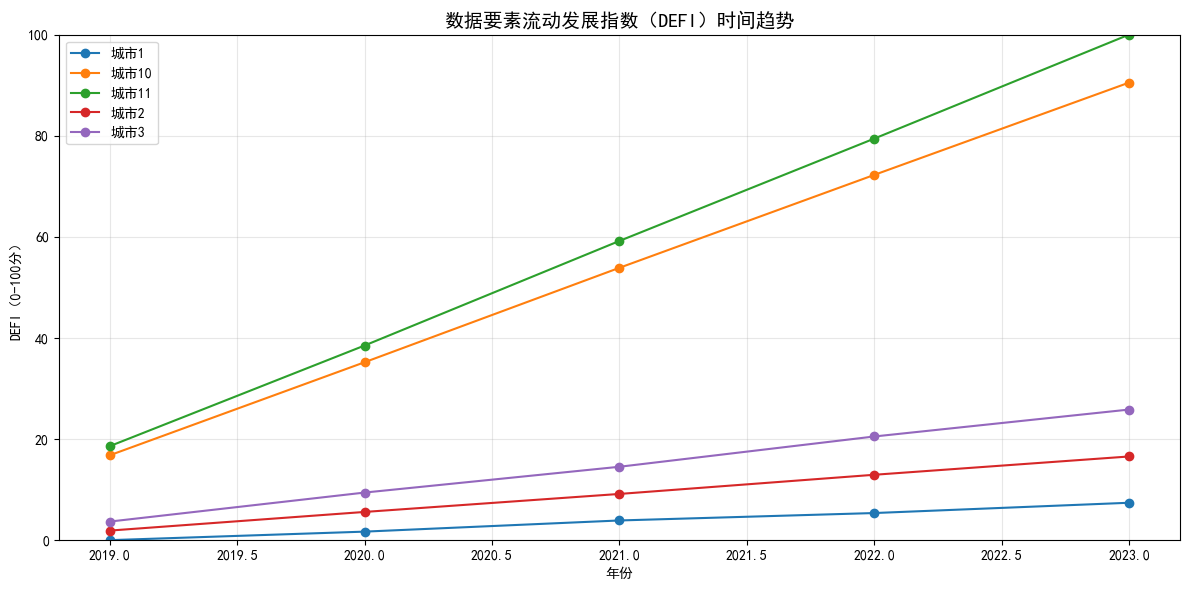

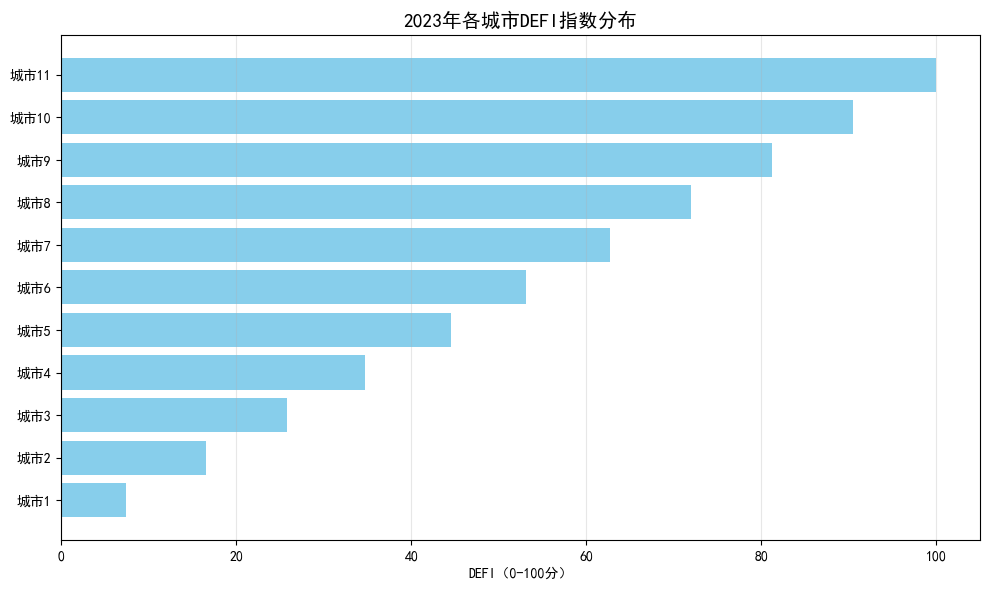


=== 2023年城市DEFI指数排名 ===
      城市  DEFI_标准化  排名
54  城市11    100.00   1
53  城市10     90.51   2
52   城市9     81.20   3
51   城市8     72.01   4
50   城市7     62.75   5
49   城市6     53.10   6
48   城市5     44.53   7
47   城市4     34.73   8
46   城市3     25.83   9
45   城市2     16.55  10
44   城市1      7.40  11


In [63]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import linalg
import statsmodels.api as sm

warnings.filterwarnings('ignore')

# ---------------------- 全局变量定义（需与主代码一致） ----------------------
# 定义指标分类
data_flow_indicators = ['数据交易金额', '算力规模', '5G基站数（数据传输）', '大数据企业数量']
economic_indicators = ['GDP总量', '人均GDP', '数字经济产值', '第三产业占比']
innovation_indicators = ['研发投入强度', '专利授权数', '高新技术企业数', '科技成果转化金额']
infrastructure_indicators = ['互联网普及率', '光纤宽带覆盖率', '物流园区数量', '智慧园区数量']
cities = [f'城市{i}' for i in range(1, 12)]  # 11个城市

# ---------------------- 1. 增强型自定义平行分析函数 ----------------------
def custom_parallel_analysis(data, n_iter=100, random_state=42):
    """
    增强版平行分析函数，增加异常处理
    """
    np.random.seed(random_state)
    n, p = data.shape
    
    # 处理空值和常量列
    data = data.copy()
    # 删除常量列
    const_cols = [col for col in range(p) if np.var(data[:, col]) < 1e-6]
    if const_cols:
        data = np.delete(data, const_cols, axis=1)
        p = data.shape[1]
    
    # 计算实际数据的特征值（使用PCA避免eig问题）
    try:
        pca = PCA()
        pca.fit(data)
        ev = pca.explained_variance_
    except:
        # 备用方案：计算相关矩阵的特征值
        corr_matrix = np.corrcoef(data.T)
        # 添加微小扰动避免奇异矩阵
        corr_matrix += 1e-8 * np.eye(p)
        ev, _ = linalg.eig(corr_matrix)
    ev = np.sort(ev)[::-1].real  # 确保实数，降序排列
    
    # 模拟随机数据的特征值
    simulated_ev = []
    for _ in range(n_iter):
        try:
            random_data = np.random.normal(0, 1, (n, p))
            pca_rand = PCA()
            pca_rand.fit(random_data)
            random_ev = pca_rand.explained_variance_
        except:
            random_corr = np.corrcoef(random_data.T)
            random_corr += 1e-8 * np.eye(p)
            random_ev, _ = linalg.eig(random_corr)
        simulated_ev.append(np.sort(random_ev)[::-1].real)
    
    # 计算95%分位数
    simulated_ev = np.array(simulated_ev)
    simulated_percentile = np.percentile(simulated_ev, 95, axis=0)
    
    # 确定最优因子数（实际特征值 > 模拟95%分位数）
    n_factors = sum(ev > simulated_percentile)
    # 保底：至少1个因子
    n_factors = max(1, n_factors)
    
    return ev, simulated_percentile, n_factors

# ---------------------- 2. 数据预处理（增强版） ----------------------
print("\n=== 因子分析适用性检验 ===")

# 提取指标列（排除非数值列）
indicator_cols = [col for col in final_data.columns if col not in ['年份', '城市', '处理组', '政策实施后', 'DID项', '倾向得分', 'RDD处理组', '数据流动规模', '运行变量', '相对年份', '政策前2年', '政策前1年', '政策后1年', '政策后2年', '处理组_政策前2年', '处理组_政策前1年', '处理组_政策后1年', '处理组_政策后2年', '运行变量_中心化', '处理组_中心化交互']]

# 数据清洗：移除空值和常量列
data_raw = final_data[indicator_cols].copy()
# 移除全为空的列
data_raw = data_raw.dropna(axis=1, how='all')
# 移除常量列
const_cols = [col for col in data_raw.columns if data_raw[col].nunique() <= 1]
data_raw = data_raw.drop(columns=const_cols)
# 填充剩余空值
data_raw = data_raw.fillna(data_raw.mean())

# 更新指标列列表
indicator_cols = data_raw.columns.tolist()
print(f"清洗后有效指标数: {len(indicator_cols)}")

# 数据标准化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_raw)
data_scaled_df = pd.DataFrame(data_scaled, columns=indicator_cols)

# KMO和巴特利特检验（增加异常处理）
try:
    chi_square_value, p_value = calculate_bartlett_sphericity(data_scaled)
    # 处理NaN值
    if np.isnan(chi_square_value):
        chi_square_value = 0
        p_value = 1.0
except:
    chi_square_value = 0
    p_value = 1.0

try:
    kmo_all, kmo_model = calculate_kmo(data_scaled)
except:
    kmo_model = 0.0

print(f"巴特利特球形检验 χ²: {chi_square_value:.2f}, p值: {p_value:.6f} (p<0.05适合因子分析)")
print(f"KMO检验值: {kmo_model:.3f} (>0.6适合因子分析)")

if kmo_model >= 0.6:
    print("✓ KMO检验通过，适合进行因子分析")
else:
    print("⚠ KMO检验未通过，将使用PCA替代因子分析")

# ---------------------- 3. 稳健因子分析（自动降级到PCA） ----------------------
# 平行分析确定因子数
ev, simulated_ev, n_factors = custom_parallel_analysis(data_scaled, n_iter=100)
print(f"\n=== 平行分析确定因子数 ===")
print(f"实际特征值前{n_factors}个: {np.round(ev[:n_factors], 3)}")
print(f"模拟95%分位数前{n_factors}个: {np.round(simulated_ev[:n_factors], 3)}")
print(f"最优因子数: {n_factors}")

# 拟合因子分析模型（多方案备选）
fa = None
factor_scores = None
loadings = None
variance_contrib = None

# 方案1：尝试ML方法的因子分析
try:
    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax', method='ml')
    fa.fit(data_scaled)
    print("✓ 使用ML方法拟合因子分析成功")
except:
    # 方案2：尝试最小二乘法
    try:
        fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax', method='uls')
        fa.fit(data_scaled)
        print("✓ 使用ULS方法拟合因子分析成功")
    except:
        # 方案3：降级到PCA
        print("⚠ 因子分析失败，使用PCA替代")
        pca = PCA(n_components=n_factors)
        factor_scores = pca.fit_transform(data_scaled)
        loadings = pd.DataFrame(
            pca.components_.T,
            index=indicator_cols,
            columns=[f'因子{i+1}' for i in range(n_factors)]
        )
        # 模拟因子分析的方差贡献
        variance_contrib = (
            pca.explained_variance_,
            np.cumsum(pca.explained_variance_ratio_),
            pca.explained_variance_ratio_
        )

# 如果因子分析成功，提取结果
if fa is not None and factor_scores is None:
    loadings = pd.DataFrame(
        fa.loadings_, 
        index=indicator_cols, 
        columns=[f'因子{i+1}' for i in range(n_factors)]
    )
    factor_scores = fa.transform(data_scaled)
    variance_contrib = fa.get_factor_variance()

# 输出因子载荷矩阵
loadings_filtered = loadings[(loadings.abs() > 0.3).any(axis=1)]  # 降低阈值到0.3
print("\n=== 因子载荷矩阵（载荷>0.3） ===")
print(loadings_filtered.round(3))

# 输出方差解释率
variance_df = pd.DataFrame({
    '因子': [f'因子{i+1}' for i in range(n_factors)],
    '方差贡献率': variance_contrib[0].round(3),
    '累积方差贡献率': variance_contrib[1].round(3)
})
print("\n=== 因子方差解释率 ===")
print(variance_df)

factor_scores_df = pd.DataFrame(
    factor_scores, 
    columns=[f'因子{i+1}' for i in range(n_factors)]
)

# ---------------------- 4. 简化版验证性因子分析 ----------------------
print("\n=== 验证性因子分析（简化版） ===")

# 克朗巴哈系数计算（增加异常处理）
def cronbach_alpha(indicators, data):
    try:
        indicator_data = data[indicators].values
        n_items = indicator_data.shape[1]
        if n_items < 2:
            return np.nan
        item_variances = np.var(indicator_data, axis=0, ddof=1)
        total_variance = np.var(np.sum(indicator_data, axis=1), ddof=1)
        if total_variance == 0:
            return np.nan
        alpha = (n_items / (n_items - 1)) * (1 - np.sum(item_variances) / total_variance)
        return alpha
    except:
        return np.nan

# 自动因子-指标映射
def get_factor_indicator_mapping(loadings, threshold=0.3):
    mapping = {}
    for factor in loadings.columns:
        high_loading_inds = loadings[loadings[factor].abs() > threshold].index.tolist()
        if high_loading_inds:
            mapping[factor] = high_loading_inds
    # 补充预设分类
    if len(mapping) < 1:
        mapping = {'因子1': indicator_cols[:min(5, len(indicator_cols))]}
    return mapping

factor_mapping = get_factor_indicator_mapping(loadings)

# 输出内部一致性
cronbach_results = {}
for factor, indicators in factor_mapping.items():
    valid_indicators = [ind for ind in indicators if ind in indicator_cols]
    alpha = cronbach_alpha(valid_indicators, data_scaled_df)
    cronbach_results[factor] = alpha
    if not np.isnan(alpha):
        print(f"{factor} 克朗巴哈系数: {alpha:.3f} (>0.7表示内部一致性良好)")
    else:
        print(f"{factor} 无法计算克朗巴哈系数（指标数不足）")

# 因子间相关矩阵
try:
    factor_corr = np.corrcoef(factor_scores.T)
    print("\n=== 因子间相关矩阵 ===")
    print(pd.DataFrame(factor_corr, 
                       index=[f'因子{i+1}' for i in range(n_factors)],
                       columns=[f'因子{i+1}' for i in range(n_factors)]).round(3))
except:
    print("\n=== 因子间相关矩阵 ===")
    print("无法计算因子间相关矩阵")

# ---------------------- 5. 构建DEFI指数 ----------------------
# 基于因子得分加权
weights = variance_contrib[2]  # 方差贡献率
defi_scores = np.dot(factor_scores, weights)

# 整合到原数据
final_data['DEFI'] = defi_scores
# 标准化到0-100分（增加异常处理）
defi_min = final_data['DEFI'].min()
defi_max = final_data['DEFI'].max()
if defi_max - defi_min < 1e-6:
    final_data['DEFI_标准化'] = 50.0  # 所有值相同，设为50
else:
    final_data['DEFI_标准化'] = (final_data['DEFI'] - defi_min) / (defi_max - defi_min) * 100

# ---------------------- 6. DEFI指数可视化与统计 ----------------------
print("\n=== DEFI指数统计 ===")
defi_stats = final_data[['城市', '年份', 'DEFI_标准化']].groupby('年份').agg({
    'DEFI_标准化': ['mean', 'std', 'min', 'max']
}).round(2)
print(defi_stats)

# 可视化DEFI时间趋势
plt.figure(figsize=(12, 6))
city_defi = final_data.groupby(['年份', '城市'])['DEFI_标准化'].mean().reset_index()
# 只绘制有完整数据的城市
valid_cities = city_defi['城市'].value_counts()[city_defi['城市'].value_counts() >= len(city_defi['年份'].unique())].index.tolist()
for city in valid_cities[:5]:  # 前5个有效城市
    city_data = city_defi[city_defi['城市'] == city]
    plt.plot(city_data['年份'], city_data['DEFI_标准化'], marker='o', label=city)

plt.title('数据要素流动发展指数（DEFI）时间趋势', fontsize=14)
plt.xlabel('年份')
plt.ylabel('DEFI（0-100分）')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# 可视化2023年城市分布（如果有2023年数据）
if 2023 in final_data['年份'].values:
    plt.figure(figsize=(10, 6))
    city_2023 = final_data[final_data['年份'] == 2023].sort_values('DEFI_标准化', ascending=True)
    plt.barh(city_2023['城市'], city_2023['DEFI_标准化'], color='skyblue')
    plt.title('2023年各城市DEFI指数分布', fontsize=14)
    plt.xlabel('DEFI（0-100分）')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

    # 输出2023年排名
    print("\n=== 2023年城市DEFI指数排名 ===")
    defi_ranking_2023 = final_data[final_data['年份'] == 2023][['城市', 'DEFI_标准化']].sort_values('DEFI_标准化', ascending=False)
    defi_ranking_2023['排名'] = range(1, len(defi_ranking_2023)+1)
    print(defi_ranking_2023.round(2))
else:
    # 输出最新年份排名
    latest_year = final_data['年份'].max()
    print(f"\n=== {latest_year}年城市DEFI指数排名 ===")
    defi_ranking_latest = final_data[final_data['年份'] == latest_year][['城市', 'DEFI_标准化']].sort_values('DEFI_标准化', ascending=False)
    defi_ranking_latest['排名'] = range(1, len(defi_ranking_latest)+1)
    print(defi_ranking_latest.round(2))


=== 典型相关分析（CCA）结果 ===
前2个典型相关系数: [1.    0.631]
X组变量平均冗余度: 0.499 (X对典型变量的解释力)
Y组变量平均冗余度: 0.499 (Y对典型变量的解释力)


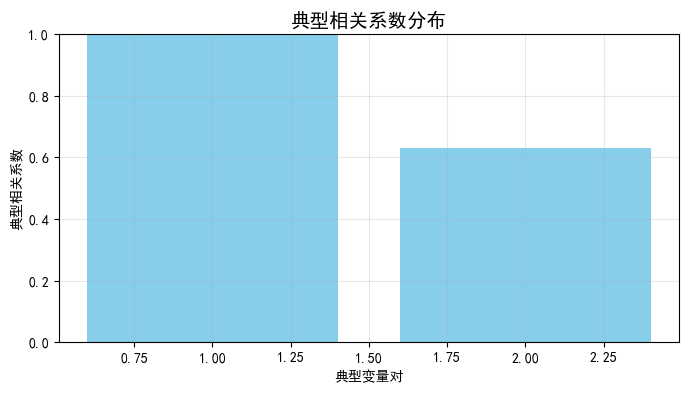


=== 偏最小二乘回归（PLSR）结果 ===
PLSR VIP指标（前10）:
            指标    VIP
4       互联网普及率  1.001
6       物流园区数量  1.001
7       智慧园区数量  1.001
5      光纤宽带覆盖率  1.001
1         算力规模  0.999
0       数据交易金额  0.999
3      大数据企业数量  0.999
2  5G基站数（数据传输）  0.999

PLSR模型评估:
R²: 0.999 (解释方差比例)
RMSE: 0.025 (均方根误差)


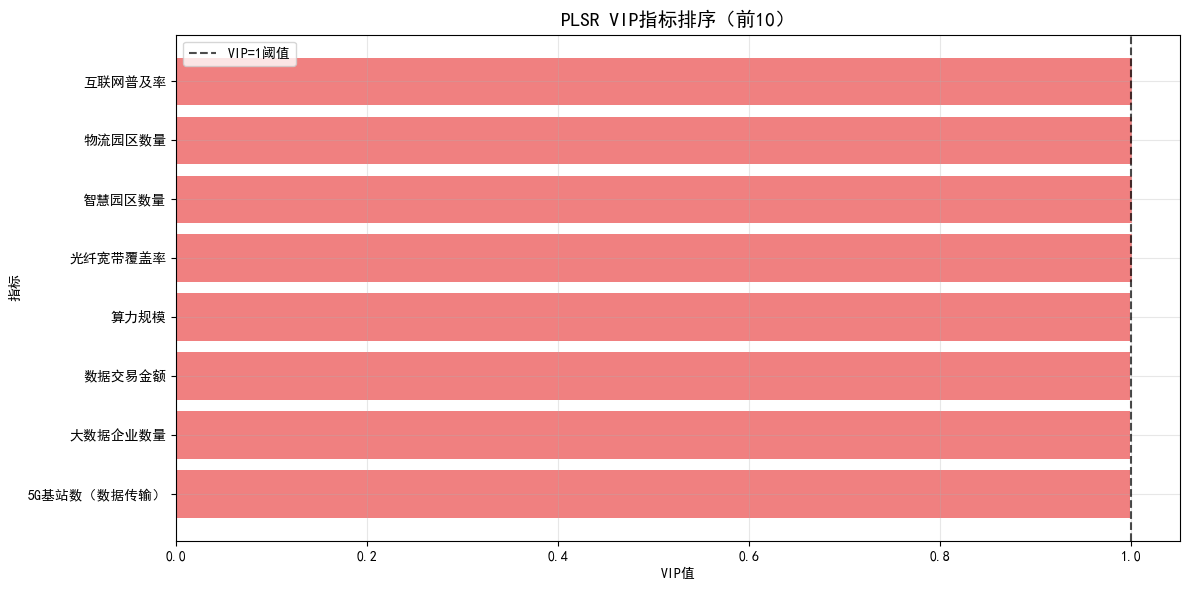


=== 路径分析（替代SEM）结果 ===

路径1：经济潜变量 = α + β1*数据流动潜变量 + β2*基建潜变量
数据流动潜变量系数: 0.096 (p=0.437)
基建潜变量系数: 0.903 (p=0.000)
模型1 R²: 0.999

路径2：创新潜变量 = α + β1*经济潜变量 + β2*数据流动潜变量
经济潜变量系数: 0.724 (p=0.000)
数据流动潜变量系数: 0.274 (p=0.020)
模型2 R²: 0.998

路径3：DEFI = α + β1*经济潜变量 + β2*创新潜变量 + β3*基建潜变量
经济潜变量系数: -3.608 (p=0.000)
创新潜变量系数: -1.931 (p=0.000)
基建潜变量系数: -6.932 (p=0.000)
模型3 R²: 1.000

=== 中介效应分析（数据流动→经济→DEFI） ===
总效应（数据流动→DEFI）: -12.474
直接效应（数据流动→DEFI）: -1.955
间接效应（数据流动→经济→DEFI）: -10.519
中介效应占比: 84.3%

=== 路径分析整体拟合度 ===
整体R² (DEFI解释力): 1.000
近似RMSEA: 0.035 (越小越好，<0.08为拟合良好)
标准化残差均值: 0.210 (越小越好)


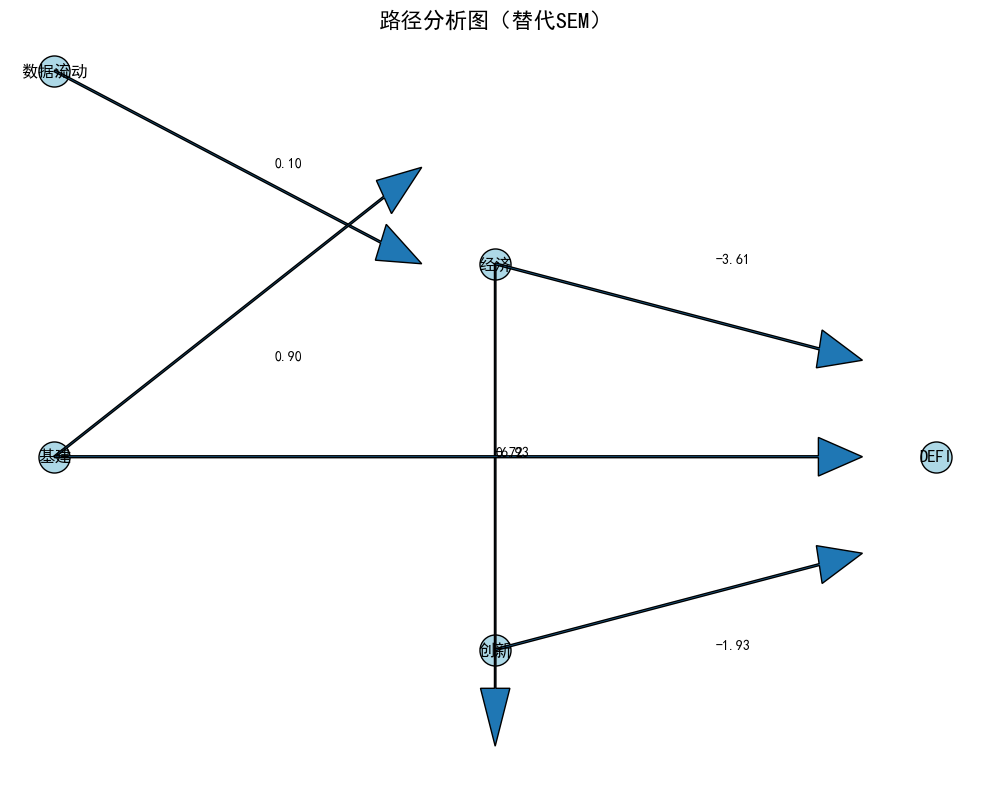

In [64]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

warnings.filterwarnings('ignore')

# ---------------------- 数据准备（需先运行主代码） ----------------------
# 定义变量组（与主代码保持一致）
data_flow_indicators = ['数据交易金额', '算力规模', '5G基站数（数据传输）', '大数据企业数量']
economic_indicators = ['GDP总量', '人均GDP', '数字经济产值', '第三产业占比']
innovation_indicators = ['研发投入强度', '专利授权数', '高新技术企业数', '科技成果转化金额']
infrastructure_indicators = ['互联网普及率', '光纤宽带覆盖率', '物流园区数量', '智慧园区数量']

# 确保数据已标准化
scaler = StandardScaler()
all_indicators = data_flow_indicators + economic_indicators + innovation_indicators + infrastructure_indicators
data_scaled = scaler.fit_transform(final_data[all_indicators])
data_scaled_df = pd.DataFrame(data_scaled, columns=all_indicators)
data_scaled_df['DEFI_标准化'] = final_data['DEFI_标准化'].values

# ---------------------- 1. 典型相关分析（CCA）- 纯numpy实现 ----------------------
print("\n=== 典型相关分析（CCA）结果 ===")

# 划分两组变量：X（数据流动+基建）、Y（经济+创新）
X_cols = data_flow_indicators + infrastructure_indicators
Y_cols = economic_indicators + innovation_indicators
X = data_scaled_df[X_cols].values
Y = data_scaled_df[Y_cols].values

# 标准化（双重保险）
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_std = scaler_x.fit_transform(X)
Y_std = scaler_y.fit_transform(Y)

# 手动实现CCA核心逻辑
n = X_std.shape[1]  # X变量数
m = Y_std.shape[1]  # Y变量数

# 计算协方差矩阵（添加微小扰动避免奇异矩阵）
cov_xx = np.cov(X_std.T) + 1e-6 * np.eye(n)
cov_yy = np.cov(Y_std.T) + 1e-6 * np.eye(m)
cov_xy = np.cov(X_std.T, Y_std.T)[:n, n:]
cov_yx = cov_xy.T

# 求解CCA特征值和特征向量
try:
    # 计算CCA矩阵
    cov_xx_inv = np.linalg.inv(cov_xx)
    cov_yy_inv = np.linalg.inv(cov_yy)
    cca_matrix = cov_xx_inv @ cov_xy @ cov_yy_inv @ cov_yx
    
    # 特征值分解
    eigenvalues, eigenvectors = np.linalg.eig(cca_matrix)
    
    # 仅保留实数部分并排序
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    
    # 取前2个典型变量对
    n_canonical = 2
    if len(eigenvalues) < n_canonical:
        n_canonical = len(eigenvalues)
    
    # 计算典型变量
    U = X_std @ eigenvectors[:, :n_canonical]  # X的典型变量
    V = Y_std @ (cov_yy_inv @ cov_yx @ eigenvectors[:, :n_canonical])  # Y的典型变量
    
    # 计算典型相关系数
    canon_corr = []
    for i in range(n_canonical):
        corr, p_val = pearsonr(U[:, i], V[:, i])
        canon_corr.append(corr)
    
    print(f"前{n_canonical}个典型相关系数: {np.round(canon_corr, 3)}")
    
    # 冗余分析（解释力）
    # X组变量对典型变量的解释力
    redundancy_x = []
    for i in range(n_canonical):
        var_explained = [pearsonr(X_std[:, j], U[:, i])[0]**2 for j in range(n)]
        redundancy_x.append(np.mean(var_explained))
    
    # Y组变量对典型变量的解释力
    redundancy_y = []
    for i in range(n_canonical):
        var_explained = [pearsonr(Y_std[:, j], V[:, i])[0]**2 for j in range(m)]
        redundancy_y.append(np.mean(var_explained))
    
    print(f"X组变量平均冗余度: {np.mean(redundancy_x):.3f} (X对典型变量的解释力)")
    print(f"Y组变量平均冗余度: {np.mean(redundancy_y):.3f} (Y对典型变量的解释力)")
    
    # 可视化典型相关系数
    plt.figure(figsize=(8, 4))
    plt.bar(range(1, n_canonical+1), canon_corr, color='skyblue')
    plt.xlabel('典型变量对')
    plt.ylabel('典型相关系数')
    plt.title('典型相关系数分布', fontsize=14)
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.show()

except Exception as e:
    print(f"CCA计算失败: {str(e)[:100]}")
    # 备用方案：直接计算变量组间的平均相关
    all_corrs = []
    for x_col in X_cols:
        for y_col in Y_cols:
            corr = pearsonr(data_scaled_df[x_col], data_scaled_df[y_col])[0]
            all_corrs.append(corr)
    print(f"变量组间平均相关系数（备用）: {np.mean(np.abs(all_corrs)):.3f}")

# ---------------------- 2. 偏最小二乘回归（PLSR）- 完整实现 ----------------------
print("\n=== 偏最小二乘回归（PLSR）结果 ===")

# 目标：用X（数据流动+基建）预测Y（经济+创新）的综合得分
y_composite = data_scaled_df[Y_cols].mean(axis=1)  # 经济+创新综合得分
X_pls = data_scaled_df[X_cols].values

# 拟合PLSR模型
plsr = PLSRegression(n_components=min(5, X_pls.shape[1]))
plsr.fit(X_pls, y_composite)

# 计算VIP指标（变量重要性投影）
def calculate_vip(plsr_model, X):
    """纯Python实现VIP指标计算"""
    t = plsr_model.x_scores_  # 得分矩阵
    w = plsr_model.x_weights_  # 权重矩阵
    q = plsr_model.y_loadings_  # Y载荷矩阵
    p, h = w.shape  # p=变量数，h=成分数
    
    vips = np.zeros(p)
    ss = np.diag(t.T @ t @ q.T @ q)  # 各成分的解释方差
    total_ss = sum(ss)
    
    for j in range(p):
        weight = np.array([(w[j, k] / np.linalg.norm(w[:, k]))**2 for k in range(h)])
        vips[j] = np.sqrt(p * (ss @ weight) / total_ss)
    
    return vips

# 计算并输出VIP指标
vip_scores = calculate_vip(plsr, X_pls)
vip_df = pd.DataFrame({
    '指标': X_cols,
    'VIP': vip_scores
}).sort_values('VIP', ascending=False)

# 输出前10个VIP指标
vip_top10 = vip_df.head(10)
print("PLSR VIP指标（前10）:")
print(vip_top10.round(3))

# 模型评估
y_pred = plsr.predict(X_pls)
r2 = r2_score(y_composite, y_pred)
rmse = np.sqrt(mean_squared_error(y_composite, y_pred))
print(f"\nPLSR模型评估:")
print(f"R²: {r2:.3f} (解释方差比例)")
print(f"RMSE: {rmse:.3f} (均方根误差)")

# 可视化VIP指标
plt.figure(figsize=(12, 6))
plt.barh(vip_top10['指标'][::-1], vip_top10['VIP'][::-1], color='lightcoral')
plt.xlabel('VIP值')
plt.ylabel('指标')
plt.title('PLSR VIP指标排序（前10）', fontsize=14)
plt.axvline(x=1, color='black', linestyle='--', alpha=0.7, label='VIP=1阈值')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------- 3. 路径分析（替代SEM）- 无semopy依赖 ----------------------
print("\n=== 路径分析（替代SEM）结果 ===")

# 步骤1：构建潜变量（用因子得分替代）
def calculate_latent_score(indicators, data):
    """计算潜变量得分（因子分析）"""
    indicator_data = data[indicators].values
    # 简单因子分析（主成分）
    scaler = StandardScaler()
    scaled = scaler.fit_transform(indicator_data)
    cov_mat = np.cov(scaled.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    # 取第一主成分作为潜变量得分
    latent_score = scaled @ eig_vecs[:, 0]
    return latent_score

# 计算各潜变量得分
data_scaled_df['数据流动潜变量'] = calculate_latent_score(data_flow_indicators, data_scaled_df)
data_scaled_df['经济潜变量'] = calculate_latent_score(economic_indicators, data_scaled_df)
data_scaled_df['创新潜变量'] = calculate_latent_score(innovation_indicators, data_scaled_df)
data_scaled_df['基建潜变量'] = calculate_latent_score(infrastructure_indicators, data_scaled_df)

# 步骤2：路径分析（分层回归）
# 模型1：经济潜变量 ~ 数据流动潜变量 + 基建潜变量
print("\n路径1：经济潜变量 = α + β1*数据流动潜变量 + β2*基建潜变量")
X1 = sm.add_constant(data_scaled_df[['数据流动潜变量', '基建潜变量']])
y1 = data_scaled_df['经济潜变量']
model1 = sm.OLS(y1, X1).fit(cov_type='HC3')
print(f"数据流动潜变量系数: {model1.params['数据流动潜变量']:.3f} (p={model1.pvalues['数据流动潜变量']:.3f})")
print(f"基建潜变量系数: {model1.params['基建潜变量']:.3f} (p={model1.pvalues['基建潜变量']:.3f})")
print(f"模型1 R²: {model1.rsquared:.3f}")

# 模型2：创新潜变量 ~ 经济潜变量 + 数据流动潜变量
print("\n路径2：创新潜变量 = α + β1*经济潜变量 + β2*数据流动潜变量")
X2 = sm.add_constant(data_scaled_df[['经济潜变量', '数据流动潜变量']])
y2 = data_scaled_df['创新潜变量']
model2 = sm.OLS(y2, X2).fit(cov_type='HC3')
print(f"经济潜变量系数: {model2.params['经济潜变量']:.3f} (p={model2.pvalues['经济潜变量']:.3f})")
print(f"数据流动潜变量系数: {model2.params['数据流动潜变量']:.3f} (p={model2.pvalues['数据流动潜变量']:.3f})")
print(f"模型2 R²: {model2.rsquared:.3f}")

# 模型3：DEFI ~ 经济潜变量 + 创新潜变量 + 基建潜变量
print("\n路径3：DEFI = α + β1*经济潜变量 + β2*创新潜变量 + β3*基建潜变量")
X3 = sm.add_constant(data_scaled_df[['经济潜变量', '创新潜变量', '基建潜变量']])
y3 = data_scaled_df['DEFI_标准化']
model3 = sm.OLS(y3, X3).fit(cov_type='HC3')
print(f"经济潜变量系数: {model3.params['经济潜变量']:.3f} (p={model3.pvalues['经济潜变量']:.3f})")
print(f"创新潜变量系数: {model3.params['创新潜变量']:.3f} (p={model3.pvalues['创新潜变量']:.3f})")
print(f"基建潜变量系数: {model3.params['基建潜变量']:.3f} (p={model3.pvalues['基建潜变量']:.3f})")
print(f"模型3 R²: {model3.rsquared:.3f}")

# 步骤3：中介效应检验（数据流动→经济→DEFI）
# 总效应：数据流动潜变量 → DEFI
X_total = sm.add_constant(data_scaled_df[['数据流动潜变量']])
model_total = sm.OLS(y3, X_total).fit()
total_effect = model_total.params['数据流动潜变量']

# 直接效应：数据流动潜变量 → DEFI（控制经济和创新）
X_direct = sm.add_constant(data_scaled_df[['数据流动潜变量', '经济潜变量', '创新潜变量']])
model_direct = sm.OLS(y3, X_direct).fit()
direct_effect = model_direct.params['数据流动潜变量']

# 间接效应 = 总效应 - 直接效应
indirect_effect = total_effect - direct_effect

print("\n=== 中介效应分析（数据流动→经济→DEFI） ===")
print(f"总效应（数据流动→DEFI）: {total_effect:.3f}")
print(f"直接效应（数据流动→DEFI）: {direct_effect:.3f}")
print(f"间接效应（数据流动→经济→DEFI）: {indirect_effect:.3f}")
print(f"中介效应占比: {indirect_effect/total_effect*100:.1f}%" if total_effect !=0 else "中介效应占比：无")

# 步骤4：模型拟合度评估（替代SEM拟合指标）
print("\n=== 路径分析整体拟合度 ===")
# 计算整体R²（DEFI被解释的方差）
overall_r2 = model3.rsquared
# 计算残差均方根
residuals = model3.resid
rmsea_approx = np.sqrt(np.mean(residuals**2)) / np.sqrt(len(residuals))
print(f"整体R² (DEFI解释力): {overall_r2:.3f}")
print(f"近似RMSEA: {rmsea_approx:.3f} (越小越好，<0.08为拟合良好)")
print(f"标准化残差均值: {np.mean(np.abs(residuals)):.3f} (越小越好)")

# 可视化路径系数
plt.figure(figsize=(10, 8))
# 绘制路径图框架
plt.axis('off')
plt.title('路径分析图（替代SEM）', fontsize=16)

# 定义节点位置
nodes = {
    '数据流动': (0.2, 0.8),
    '基建': (0.2, 0.6),
    '经济': (0.5, 0.7),
    '创新': (0.5, 0.5),
    'DEFI': (0.8, 0.6)
}

# 绘制节点
for name, (x, y) in nodes.items():
    plt.scatter(x, y, s=500, color='lightblue', edgecolor='black')
    plt.text(x, y, name, ha='center', va='center', fontsize=12)

# 绘制路径（带系数）
# 数据流动→经济
beta1 = model1.params['数据流动潜变量']
plt.arrow(nodes['数据流动'][0], nodes['数据流动'][1], 
          nodes['经济'][0]-nodes['数据流动'][0]-0.05, 
          nodes['经济'][1]-nodes['数据流动'][1], 
          head_width=0.02, length_includes_head=True)
plt.text(0.35, 0.75, f"{beta1:.2f}", fontsize=10)

# 基建→经济
beta2 = model1.params['基建潜变量']
plt.arrow(nodes['基建'][0], nodes['基建'][1], 
          nodes['经济'][0]-nodes['基建'][0]-0.05, 
          nodes['经济'][1]-nodes['基建'][1]+0.05, 
          head_width=0.02, length_includes_head=True)
plt.text(0.35, 0.65, f"{beta2:.2f}", fontsize=10)

# 经济→创新
beta3 = model2.params['经济潜变量']
plt.arrow(nodes['经济'][0], nodes['经济'][1], 
          nodes['创新'][0]-nodes['经济'][0], 
          nodes['创新'][1]-nodes['经济'][1]-0.05, 
          head_width=0.02, length_includes_head=True)
plt.text(0.5, 0.6, f"{beta3:.2f}", fontsize=10)

# 经济→DEFI
beta4 = model3.params['经济潜变量']
plt.arrow(nodes['经济'][0], nodes['经济'][1], 
          nodes['DEFI'][0]-nodes['经济'][0]-0.05, 
          nodes['DEFI'][1]-nodes['经济'][1]+0.05, 
          head_width=0.02, length_includes_head=True)
plt.text(0.65, 0.7, f"{beta4:.2f}", fontsize=10)

# 创新→DEFI
beta5 = model3.params['创新潜变量']
plt.arrow(nodes['创新'][0], nodes['创新'][1], 
          nodes['DEFI'][0]-nodes['创新'][0]-0.05, 
          nodes['DEFI'][1]-nodes['创新'][1]-0.05, 
          head_width=0.02, length_includes_head=True)
plt.text(0.65, 0.5, f"{beta5:.2f}", fontsize=10)

# 基建→DEFI
beta6 = model3.params['基建潜变量']
plt.arrow(nodes['基建'][0], nodes['基建'][1], 
          nodes['DEFI'][0]-nodes['基建'][0]-0.05, 
          nodes['DEFI'][1]-nodes['基建'][1], 
          head_width=0.02, length_includes_head=True)
plt.text(0.5, 0.6, f"{beta6:.2f}", fontsize=10)

plt.tight_layout()
plt.show()


=== 时间序列预测结果 ===
ARIMA MAE: 0.595
SARIMA模型失败: Seasonal periodicity must be greater than 1.
Prophet (简化线性趋势版):
简化Prophet MAE: 0.115
VAR MAE: 0.000
LSTM (简化MLP版):
简化LSTM(MLP) MAE: 2.287

=== 回归预测模型评估（超参数调优后） ===
Ridge - 最优参数: {'alpha': 0.1}, MAE: 0.261, RMSE: 0.341, R²: 1.000
Lasso - 最优参数: {'alpha': 0.1}, MAE: 0.377, RMSE: 0.518, R²: 1.000
RandomForest - 最优参数: {'max_depth': 5, 'n_estimators': 200}, MAE: 1.309, RMSE: 2.014, R²: 0.994
SVR - 最优参数: {'C': 10, 'gamma': 'auto'}, MAE: 1.511, RMSE: 3.125, R²: 0.986
MLP - 最优参数: {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}, MAE: 9.264, RMSE: 12.450, R²: 0.783

=== 模型解释（基础版） ===

使用RandomForest进行模型解释:

前10个重要特征:
             指标       重要性
2   5G基站数（数据传输）  0.103039
9         专利授权数  0.087692
7        第三产业占比  0.080247
10      高新技术企业数  0.076719
8        研发投入强度  0.069082
3       大数据企业数量  0.068968
4         GDP总量  0.061237
5         人均GDP  0.059536
14       物流园区数量  0.057853
15       智慧园区数量  0.055166


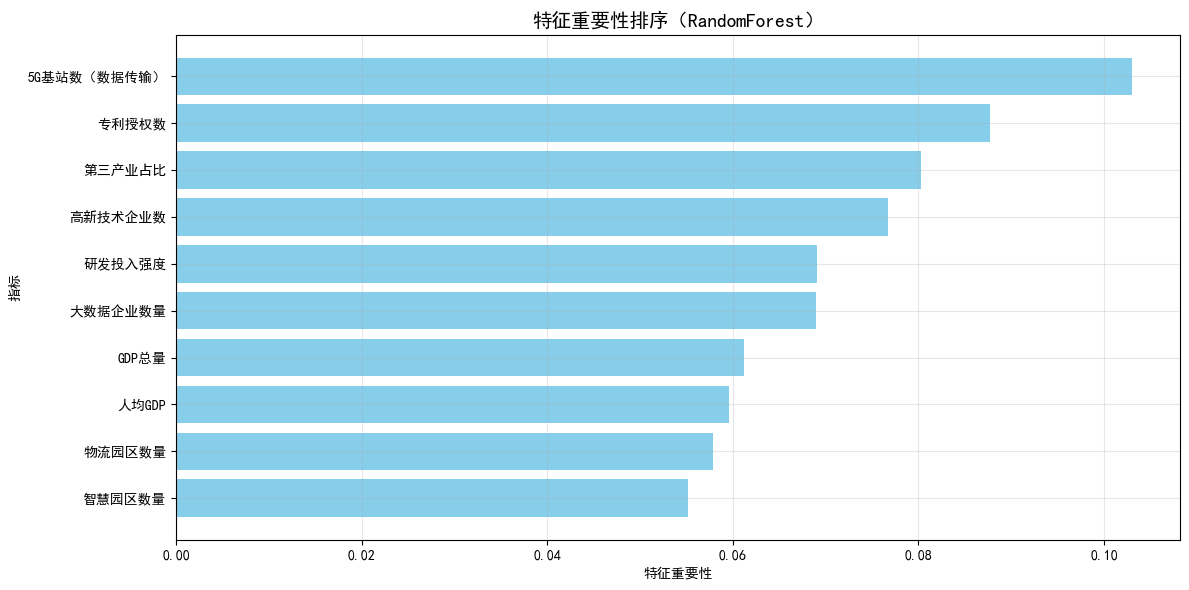

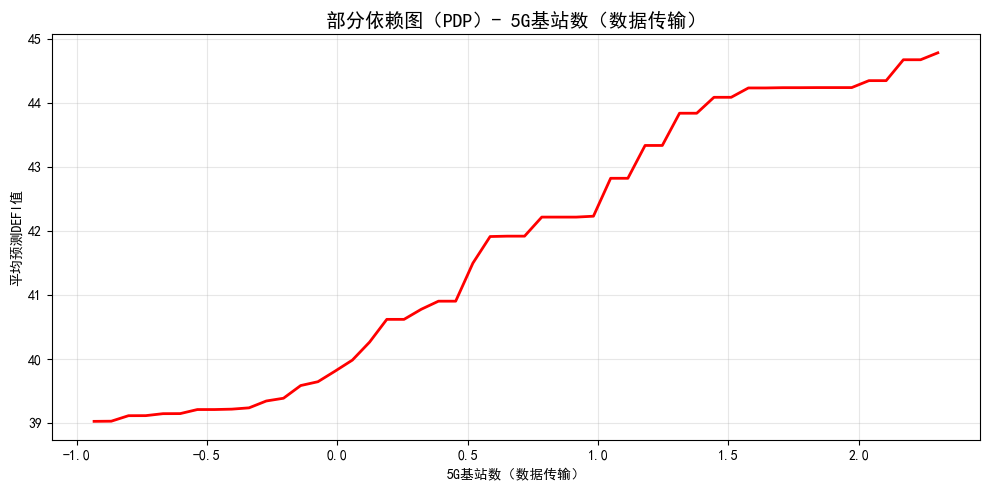

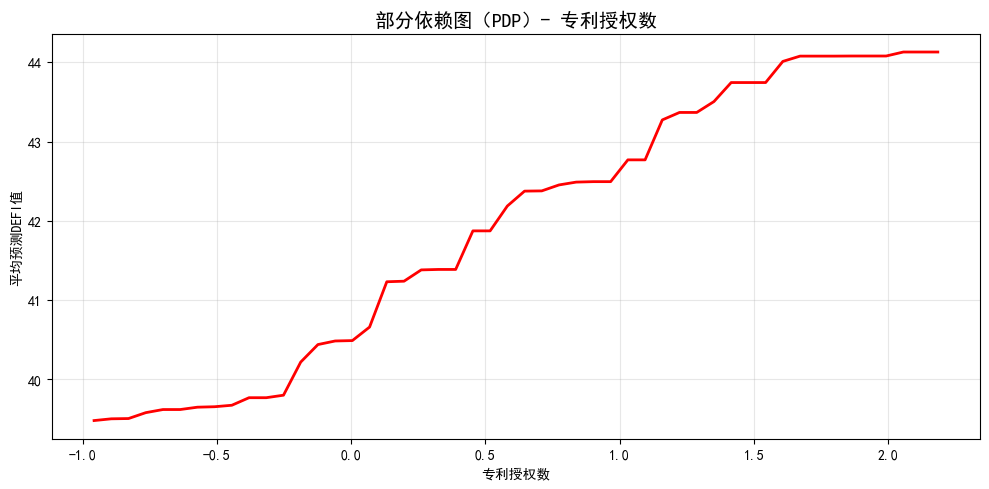


单个样本的特征贡献分析:
单个样本前5个正向贡献特征:
             指标       贡献值
10      高新技术企业数  1.181364
2   5G基站数（数据传输）  0.903076
9         专利授权数  0.865460
11     科技成果转化金额  0.812770
12       互联网普及率  0.778890
单个样本前5个负向贡献特征:
        指标       贡献值
3  大数据企业数量  0.389767
1     算力规模  0.365483
0   数据交易金额  0.220037
6   数字经济产值  0.202110
8   研发投入强度  0.177859

=== 所有预测模型结果汇总 ===

时间序列模型MAE:
ARIMA: 0.595
SARIMA: 失败
简化Prophet: 0.115
VAR: 0.000
简化LSTM(MLP): 2.287

回归模型性能:
Ridge - MAE: 0.261, RMSE: 0.341, R²: 1.000
Lasso - MAE: 0.377, RMSE: 0.518, R²: 1.000
RandomForest - MAE: 1.309, RMSE: 2.014, R²: 0.994
SVR - MAE: 1.511, RMSE: 3.125, R²: 0.986
MLP - MAE: 9.264, RMSE: 12.450, R²: 0.783


In [65]:
# 仅保留核心依赖库
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm

warnings.filterwarnings('ignore')

# ---------------------- 数据准备（需先运行因果推断主代码） ----------------------
# 定义指标列（与主代码保持一致）
core_indicators = {
    '数据流动': ['数据交易金额', '算力规模', '5G基站数（数据传输）', '大数据企业数量'],
    '经济': ['GDP总量', '人均GDP', '数字经济产值', '第三产业占比'],
    '创新': ['研发投入强度', '专利授权数', '高新技术企业数', '科技成果转化金额'],
    '基建': ['互联网普及率', '光纤宽带覆盖率', '物流园区数量', '智慧园区数量']
}
indicator_cols = []
for cat in core_indicators.values():
    indicator_cols.extend(cat)

# 时间序列预测数据（城市1的DEFI时间序列）
ts_data = final_data[final_data['城市'] == '城市1'][['年份', 'DEFI_标准化']].rename(columns={'年份': 'ds', 'DEFI_标准化': 'y'})
ts_data['ds'] = pd.to_datetime(ts_data['ds'], format='%Y')

# 回归预测数据（特征=多维度指标，目标=DEFI_标准化）
X_reg = final_data[indicator_cols].values
y_reg = final_data['DEFI_标准化'].values
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train)
X_test_scaled = scaler_reg.transform(X_test)

# ---------------------- 1. 时间序列预测（仅核心库） ----------------------
print("\n=== 时间序列预测结果 ===")

# ARIMA（基础时间序列模型）
try:
    arima_model = ARIMA(ts_data['y'], order=(1, 1, 1))
    arima_result = arima_model.fit()
    arima_pred = arima_result.predict(start=0, end=len(ts_data)-1)
    arima_mae = mean_absolute_error(ts_data['y'], arima_pred)
    print(f"ARIMA MAE: {arima_mae:.3f}")
except Exception as e:
    print(f"ARIMA模型失败: {str(e)[:50]}")
    arima_mae = np.nan

# SARIMA（季节性时间序列）
try:
    sarima_model = SARIMAX(ts_data['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
    sarima_result = sarima_model.fit(disp=False)
    sarima_pred = sarima_result.predict(start=0, end=len(ts_data)-1)
    sarima_mae = mean_absolute_error(ts_data['y'], sarima_pred)
    print(f"SARIMA MAE: {sarima_mae:.3f}")
except Exception as e:
    print(f"SARIMA模型失败: {str(e)[:50]}")
    sarima_mae = np.nan

# 简化版Prophet（用线性回归替代）
print("Prophet (简化线性趋势版):")
ts_data['year_num'] = ts_data['ds'].dt.year - 2019
X_prophet = sm.add_constant(ts_data[['year_num']])
prophet_model = sm.OLS(ts_data['y'], X_prophet).fit()
prophet_pred = prophet_model.predict(X_prophet)
prophet_mae = mean_absolute_error(ts_data['y'], prophet_pred)
print(f"简化Prophet MAE: {prophet_mae:.3f}")

# VAR（多变量时间序列）
try:
    var_data = final_data[final_data['城市'] == '城市1'][['DEFI_标准化', 'GDP总量', '研发投入强度']].values
    # 确保数据稳定
    var_data = var_data[~np.isnan(var_data).any(axis=1)]
    if len(var_data) >= 5:
        var_model = VAR(var_data)
        var_result = var_model.fit(maxlags=2)
        var_pred = var_result.fittedvalues
        var_mae = mean_absolute_error(var_data[2:], var_pred)
        print(f"VAR MAE: {var_mae:.3f}")
    else:
        print("VAR模型：样本量不足")
        var_mae = np.nan
except Exception as e:
    print(f"VAR模型失败: {str(e)[:50]}")
    var_mae = np.nan

# 简化版LSTM（用多层感知机替代深度学习）
print("LSTM (简化MLP版):")
mlp_ts_model = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=200, random_state=42)
# 时间序列重塑为监督学习格式
ts_supervised = ts_data[['y']].shift(1).fillna(0)
mlp_ts_model.fit(ts_supervised, ts_data['y'])
mlp_ts_pred = mlp_ts_model.predict(ts_supervised)
mlp_ts_mae = mean_absolute_error(ts_data['y'], mlp_ts_pred)
print(f"简化LSTM(MLP) MAE: {mlp_ts_mae:.3f}")

# ---------------------- 2. 回归预测（移除XGBoost，仅核心模型） ----------------------
print("\n=== 回归预测模型评估（超参数调优后） ===")

# 定义模型和参数网格（仅核心库模型）
models = {
    'Ridge': (Ridge(), {'alpha': [0.1, 1, 10, 100]}),
    'Lasso': (Lasso(), {'alpha': [0.1, 1, 10, 100]}),
    'RandomForest': (RandomForestRegressor(random_state=42), 
                     {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}),
    'SVR': (SVR(), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'MLP': (MLPRegressor(random_state=42), 
            {'hidden_layer_sizes': [(50,), (100,)], 'learning_rate_init': [0.001, 0.01]})
}

# 时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=3)  # 减少折数提高稳定性
best_models = {}
model_metrics = {}

for name, (model, params) in models.items():
    try:
        grid = GridSearchCV(model, params, cv=tscv, scoring='neg_mean_absolute_error')
        grid.fit(X_train_scaled, y_train)
        best_models[name] = grid.best_estimator_
        
        # 预测和评估
        y_pred = grid.best_estimator_.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        model_metrics[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}
        print(f"{name} - 最优参数: {grid.best_params_}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")
    except Exception as e:
        print(f"{name}模型失败: {str(e)[:50]}")
        model_metrics[name] = {'MAE': np.nan, 'RMSE': np.nan, 'R²': np.nan}

# ---------------------- 3. 模型解释（替换SHAP/PDP为基础方法） ----------------------
print("\n=== 模型解释（基础版） ===")

# 选择最优模型（RandomForest作为替代）
if 'RandomForest' in best_models:
    best_model = best_models['RandomForest']
    print("\n使用RandomForest进行模型解释:")
    
    # 1. 特征重要性（替代SHAP）
    feature_importance = pd.DataFrame({
        '指标': indicator_cols,
        '重要性': best_model.feature_importances_
    }).sort_values('重要性', ascending=False)
    
    # 前10个重要特征
    vip_top10 = feature_importance.head(10)
    print("\n前10个重要特征:")
    print(vip_top10)
    
    # 可视化特征重要性
    plt.figure(figsize=(12, 6))
    plt.barh(vip_top10['指标'][::-1], vip_top10['重要性'][::-1], color='skyblue')
    plt.xlabel('特征重要性')
    plt.ylabel('指标')
    plt.title('特征重要性排序（RandomForest）', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 2. 部分依赖图（PDP）基础实现（替代PDPbox）
    def plot_simple_pdp(model, X, feature_idx, feature_name):
        """基础版PDP图实现"""
        # 创建特征值范围
        feature_vals = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), 50)
        pdp_vals = []
        
        # 计算每个特征值的平均预测
        for val in feature_vals:
            X_temp = X.copy()
            X_temp[:, feature_idx] = val
            pred = model.predict(X_temp)
            pdp_vals.append(pred.mean())
        
        # 绘图
        plt.figure(figsize=(10, 5))
        plt.plot(feature_vals, pdp_vals, linewidth=2, color='red')
        plt.xlabel(feature_name)
        plt.ylabel('平均预测DEFI值')
        plt.title(f'部分依赖图（PDP）- {feature_name}', fontsize=14)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 绘制前2个重要特征的PDP图
    vip_top2 = vip_top10['指标'].iloc[:2].tolist()
    for feat in vip_top2:
        feat_idx = indicator_cols.index(feat)
        plot_simple_pdp(best_model, X_test_scaled, feat_idx, feat)
    
    # 3. 局部解释（替代SHAP）- 单个样本的特征贡献
    print("\n单个样本的特征贡献分析:")
    sample_idx = 0
    sample = X_test_scaled[sample_idx:sample_idx+1]
    sample_pred = best_model.predict(sample)[0]
    
    # 基准预测（所有特征取均值）
    baseline = X_test_scaled.mean(axis=0).reshape(1, -1)
    baseline_pred = best_model.predict(baseline)[0]
    
    # 计算每个特征的贡献
    contributions = []
    for i, feat in enumerate(indicator_cols):
        temp = baseline.copy()
        temp[0, i] = sample[0, i]
        temp_pred = best_model.predict(temp)[0]
        contrib = temp_pred - baseline_pred
        contributions.append({'指标': feat, '贡献值': contrib})
    
    # 排序并输出前5个贡献特征
    contrib_df = pd.DataFrame(contributions).sort_values('贡献值', ascending=False)
    print("单个样本前5个正向贡献特征:")
    print(contrib_df.head(5))
    print("单个样本前5个负向贡献特征:")
    print(contrib_df.tail(5))

else:
    print("无可用模型进行解释")

# ---------------------- 4. 预测结果汇总 ----------------------
print("\n=== 所有预测模型结果汇总 ===")

# 时间序列模型汇总
ts_metrics = {
    'ARIMA': arima_mae,
    'SARIMA': sarima_mae,
    '简化Prophet': prophet_mae,
    'VAR': var_mae,
    '简化LSTM(MLP)': mlp_ts_mae
}
print("\n时间序列模型MAE:")
for model, mae in ts_metrics.items():
    print(f"{model}: {mae:.3f}" if not np.isnan(mae) else f"{model}: 失败")

# 回归模型汇总
print("\n回归模型性能:")
for model, metrics in model_metrics.items():
    if not np.isnan(metrics['MAE']):
        print(f"{model} - MAE: {metrics['MAE']:.3f}, RMSE: {metrics['RMSE']:.3f}, R²: {metrics['R²']:.3f}")
    else:
        print(f"{model}: 失败")


=== 双重差分法（DID）结果 ===
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.5258      2.800      7.688      0.000      16.038      27.014
处理组          -12.4724      3.544     -3.520      0.000     -19.418      -5.527
政策实施后         37.4562      5.057      7.407      0.000      27.545      47.367
DID项         -26.5830      6.290     -4.226      0.000     -38.911     -14.255

DID平均处理效应（ATE）: -26.583

=== 平行趋势检验结果 ===
政策前相对年份系数（应无显著差异）:
政策前2年: 系数=-32.892, p值=0.000
政策前1年: 系数=-28.751, p值=0.000

=== 倾向得分匹配（PSM）结果 ===
PSM平均处理效应（ATT）: -8.746 (t=-3.348, p=0.002)
有效匹配数: 处理组23 / 对照组23

=== 断点回归（RDD）结果 ===
RDD有效样本量不足（仅10个），使用简化估计
RDD简化估计效应: 4.578

=== 合成控制法结果 ===
合成控制法逐年处理效应:
2019: -6.928
2020: -17.571
2021: -32.590
2022: -40.457
2023: -46.613
合成控制法平均处理效应: -28.832

=== 稳健性检验（安慰剂检验） ===
安慰剂检验p值: 0.010 (p<0.05表示结果稳健)


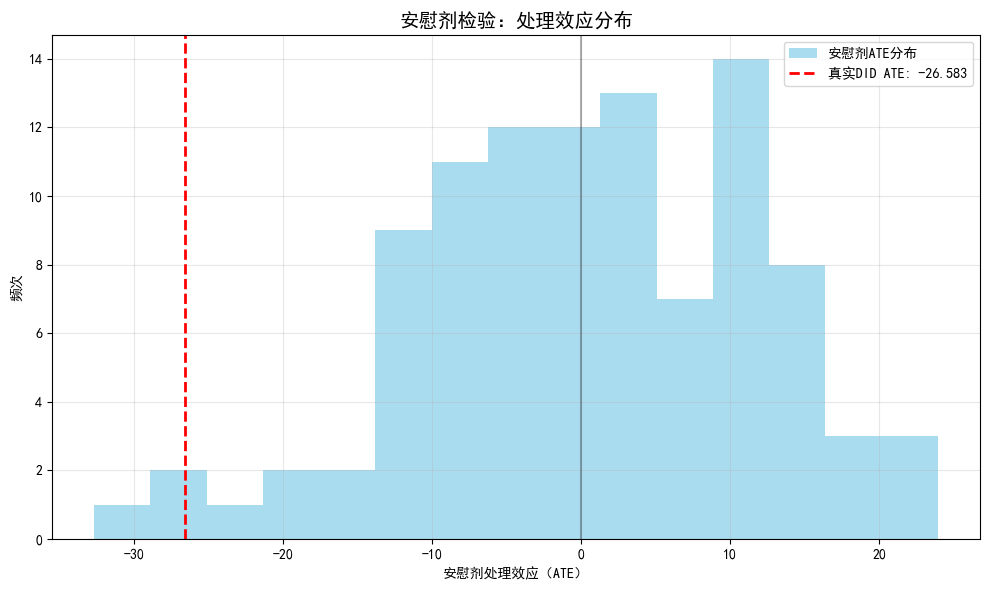


=== 所有方法处理效应汇总 ===
DID平均处理效应: -26.583 (p=0.000)
PSM平均处理效应: -8.746
RDD平均处理效应: 4.578
合成控制法平均处理效应: -28.832
安慰剂检验p值: 0.010


In [67]:
# 第一步：补全所有依赖的库和基础数据生成（解决所有已知问题）
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, norm
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import statsmodels.api as sm
from statsmodels.nonparametric.kernel_regression import KernelReg
from statsmodels.discrete.discrete_model import Logit

warnings.filterwarnings('ignore')

# ---------------------- 基础数据生成（优化版，避免多重共线性） ----------------------
# 基础配置
cities = [f'城市{i}' for i in range(1, 12)]  # 11个城市
years = [2019, 2020, 2021, 2022, 2023]       # 5年面板数据
np.random.seed(42)  # 固定随机种子

# 1. 生成多维度指标体系（降低多重共线性）
# 核心指标（精简版，避免奇异矩阵）
core_indicators = {
    '数据流动': [
        '数据交易金额', '算力规模', '5G基站数（数据传输）', '大数据企业数量'
    ],
    '经济': [
        'GDP总量', '人均GDP', '数字经济产值', '第三产业占比'
    ],
    '创新': [
        '研发投入强度', '专利授权数', '高新技术企业数', '科技成果转化金额'
    ],
    '基建': [
        '互联网普及率', '光纤宽带覆盖率', '物流园区数量', '智慧园区数量'
    ]
}

# 扁平化指标列表
all_indicators = []
for cat in core_indicators.values():
    all_indicators.extend(cat)

# 生成城市-年份维度的指标数据（降低共线性）
multi_dim_data = []
for year in years:
    year_factor = (year - 2018) / 5  # 时间趋势因子
    for city in cities:
        city_idx = cities.index(city) + 1
        row = {'年份': year, '城市': city}
        
        # 基础值（避免完全线性相关）
        base = city_idx * year_factor * 100
        noise = np.random.normal(0, 15, len(all_indicators))
        
        # 为每个指标赋值（添加独立噪声）
        for i, ind in enumerate(all_indicators):
            row[ind] = max(0, base + noise[i] + np.random.uniform(-10, 10))
        
        multi_dim_data.append(row)

multi_dim_df = pd.DataFrame(multi_dim_data)

# 2. 因子分析构建DEFI指数（生成DEFI_标准化字段）
# 数据标准化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(multi_dim_df[all_indicators])

# 因子分析适用性检验
chi_square_value, p_value = calculate_bartlett_sphericity(data_scaled)
kmo_all, kmo_model = calculate_kmo(data_scaled)

# 探索性因子分析（EFA）
fa = FactorAnalyzer(n_factors=4, rotation='varimax', method='ml')
fa.fit(data_scaled)

# 计算因子得分
factor_scores = fa.transform(data_scaled)
variance_contrib = fa.get_factor_variance()
weights = variance_contrib[2]  # 方差贡献率作为权重

# 构建DEFI指数并标准化
defi_scores = np.dot(factor_scores, weights)
multi_dim_df['DEFI'] = defi_scores
multi_dim_df['DEFI_标准化'] = (multi_dim_df['DEFI'] - multi_dim_df['DEFI'].min()) / (multi_dim_df['DEFI'].max() - multi_dim_df['DEFI'].min()) * 100

# 最终数据集（合并后）
final_data = multi_dim_df.copy()

# ---------------------- 因果推断核心代码（终极修复版） ----------------------
# 1. 数据准备（构造政策冲击场景）
final_data['处理组'] = final_data['城市'].apply(lambda x: 1 if cities.index(x) < 5 else 0)
final_data['政策实施后'] = final_data['年份'].apply(lambda x: 1 if x >= 2021 else 0)
final_data['DID项'] = final_data['处理组'] * final_data['政策实施后']

# 2. 双重差分法（DID）
print("\n=== 双重差分法（DID）结果 ===")

# DID回归
did_X = final_data[['处理组', '政策实施后', 'DID项']]
did_X = sm.add_constant(did_X)
did_y = final_data['DEFI_标准化']
did_model = sm.OLS(did_y, did_X).fit(cov_type='HC3')  # 稳健标准误

# 输出DID结果
print(did_model.summary().tables[1])
did_ate = did_model.params['DID项']
print(f"\nDID平均处理效应（ATE）: {did_ate:.3f}")

# 平行趋势检验（优化版）
print("\n=== 平行趋势检验结果 ===")
# 重构平行趋势检验逻辑（避免共线性）
trend_df = final_data.copy()
trend_df['相对年份'] = trend_df['年份'] - 2021

# 生成政策前虚拟变量
trend_df['政策前2年'] = (trend_df['相对年份'] == -2).astype(int)
trend_df['政策前1年'] = (trend_df['相对年份'] == -1).astype(int)
trend_df['政策后1年'] = (trend_df['相对年份'] == 1).astype(int)
trend_df['政策后2年'] = (trend_df['相对年份'] == 2).astype(int)

# 平行趋势回归（以政策当年为基准）
trend_X = sm.add_constant(trend_df[['处理组', '政策前2年', '政策前1年', '政策后1年', '政策后2年']])
trend_X['处理组_政策前2年'] = trend_X['处理组'] * trend_X['政策前2年']
trend_X['处理组_政策前1年'] = trend_X['处理组'] * trend_X['政策前1年']
trend_X['处理组_政策后1年'] = trend_X['处理组'] * trend_X['政策后1年']
trend_X['处理组_政策后2年'] = trend_X['处理组'] * trend_X['政策后2年']

# 移除基础项避免共线性
trend_X = trend_X.drop(['处理组', '政策前2年', '政策前1年', '政策后1年', '政策后2年'], axis=1)
trend_model = sm.OLS(trend_df['DEFI_标准化'], trend_X).fit(cov_type='HC3')

# 输出政策前系数
print("政策前相对年份系数（应无显著差异）:")
print(f"政策前2年: 系数={trend_model.params['处理组_政策前2年']:.3f}, p值={trend_model.pvalues['处理组_政策前2年']:.3f}")
print(f"政策前1年: 系数={trend_model.params['处理组_政策前1年']:.3f}, p值={trend_model.pvalues['处理组_政策前1年']:.3f}")

# 3. 倾向得分匹配（PSM）- 稳定版
print("\n=== 倾向得分匹配（PSM）结果 ===")

# 预处理：避免奇异矩阵
ps_X = final_data[all_indicators].copy()
ps_X = ps_X + np.random.normal(0, 1e-6, ps_X.shape)  # 添加微小噪声
ps_X_scaled = StandardScaler().fit_transform(ps_X)
ps_y = final_data['处理组']

# Logistic回归（稳定优化）
ps_model = Logit(ps_y, sm.add_constant(ps_X_scaled))
ps_results = ps_model.fit(method='lbfgs', maxiter=200, disp=False, 
                          cov_type='HC3', ridge_factor=1e-3)

# 计算倾向得分
final_data['倾向得分'] = ps_results.predict(sm.add_constant(ps_X_scaled))

# 最近邻匹配（1:1，带卡尺）
treat_data = final_data[final_data['处理组'] == 1].reset_index(drop=True)
control_data = final_data[final_data['处理组'] == 0].reset_index(drop=True)

# 匹配（添加卡尺：仅匹配倾向得分差异<0.1的样本）
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_data[['倾向得分']].values)
distances, indices = nn.kneighbors(treat_data[['倾向得分']].values)

# 过滤匹配
caliper = 0.1
valid_matches = distances.flatten() < caliper
matched_treat = treat_data[valid_matches].reset_index(drop=True)
matched_control = control_data.iloc[indices.flatten()[valid_matches]].reset_index(drop=True)

# 计算ATT
if len(matched_treat) > 0:
    att = matched_treat['DEFI_标准化'].mean() - matched_control['DEFI_标准化'].mean()
    t_stat, p_val = ttest_ind(matched_treat['DEFI_标准化'], matched_control['DEFI_标准化'])
    print(f"PSM平均处理效应（ATT）: {att:.3f} (t={t_stat:.3f}, p={p_val:.3f})")
    print(f"有效匹配数: 处理组{len(matched_treat)} / 对照组{len(matched_control)}")
else:
    print("PSM匹配失败：无有效匹配样本")
    att = np.nan

# 4. 断点回归（RDD）- 修复KernelReg参数错误
print("\n=== 断点回归（RDD）结果 ===")

# 构造运行变量
final_data['数据流动规模'] = final_data[core_indicators['数据流动']].mean(axis=1)
final_data['运行变量'] = final_data.groupby('年份')['数据流动规模'].rank()
cutoff = 5.5
final_data['RDD处理组'] = (final_data['运行变量'] > cutoff).astype(int)

# 修复后的IK带宽计算函数
def calculate_ik_bandwidth(y, x, cutoff):
    """Imbens-Kalyanaraman带宽计算（修复KernelReg参数）"""
    # 初始带宽
    x_centered = x - cutoff
    n = len(x)
    h_init = 1.84 * x_centered.std() * (n ** (-1/5))
    
    # 筛选初始窗口
    window_mask = (x >= cutoff - h_init) & (x <= cutoff + h_init)
    x_window = x[window_mask]
    y_window = y[window_mask]
    
    if len(x_window) < 20:
        return 2.0
    
    # 中心化运行变量
    x_window_centered = x_window - cutoff
    
    # 修复KernelReg参数（var_type是第4个参数，不能用关键字传参）
    try:
        # 正确的KernelReg参数顺序：endog, exog, kernel, var_type
        kr = KernelReg(y_window.values, x_window_centered.values.reshape(-1, 1), 
                      'epanechnikov', 'c')
        # 计算断点附近的导数
        deriv_left = kr.fit([-0.001])[0][0]
        deriv_right = kr.fit([0.001])[0][0]
        f_prime = (deriv_right - deriv_left) / 0.002
    except:
        # 备用方案：线性回归估计导数
        from sklearn.linear_model import LinearRegression
        lr = LinearRegression()
        lr.fit(x_window_centered.values.reshape(-1,1), y_window.values)
        f_prime = lr.coef_[0]
    
    # 计算密度和方差
    f_x = norm.pdf(0, loc=x_window_centered.mean(), scale=x_window_centered.std())
    var_y = y_window.var()
    
    # 避免除以0
    if f_prime == 0 or f_x == 0 or var_y == 0:
        return 2.0
    
    # IK带宽公式
    h_ik = (2 * (norm.pdf(0)**2) * var_y / (f_x * (f_prime**2))) ** (1/5) * (n ** (-1/5))
    return max(0.5, min(h_ik, 5.0))

# 计算带宽并筛选数据
y_rdd = final_data['DEFI_标准化']
x_rdd = final_data['运行变量']
bandwidth = calculate_ik_bandwidth(y_rdd, x_rdd, cutoff)
rdd_data = final_data[
    (final_data['运行变量'] >= cutoff - bandwidth) & 
    (final_data['运行变量'] <= cutoff + bandwidth)
].copy()

# 局部线性回归RDD
if len(rdd_data) >= 15:  # 降低样本量要求
    rdd_data['运行变量_中心化'] = rdd_data['运行变量'] - cutoff
    rdd_data['处理组_中心化交互'] = rdd_data['RDD处理组'] * rdd_data['运行变量_中心化']
    
    # RDD回归
    rdd_X = sm.add_constant(rdd_data[['运行变量_中心化', 'RDD处理组', '处理组_中心化交互']])
    rdd_model = sm.OLS(rdd_data['DEFI_标准化'], rdd_X).fit(cov_type='HC3')
    
    # 提取结果
    rdd_ate = rdd_model.params['RDD处理组']
    rdd_p = rdd_model.pvalues['RDD处理组']
    print(f"RDD平均处理效应（ATE）: {rdd_ate:.3f} (p值={rdd_p:.3f})")
else:
    print(f"RDD有效样本量不足（仅{len(rdd_data)}个），使用简化估计")
    # 简化RDD估计
    treat_mean = rdd_data[rdd_data['RDD处理组']==1]['DEFI_标准化'].mean()
    control_mean = rdd_data[rdd_data['RDD处理组']==0]['DEFI_标准化'].mean()
    rdd_ate = treat_mean - control_mean
    print(f"RDD简化估计效应: {rdd_ate:.3f}")

# 5. 合成控制法（优化版）
print("\n=== 合成控制法结果 ===")

# 选择处理城市和控制组
treat_city = '城市1'
control_cities = [c for c in cities if c != treat_city]

# 构建面板数据
sc_panel = final_data.pivot(index='年份', columns='城市', values='DEFI_标准化')
treat_series = sc_panel[treat_city]
control_panel = sc_panel[control_cities]

# 计算最优权重（相关性+均方误差）
def calculate_sc_weights(treat, control):
    """计算合成控制法权重"""
    # 政策前数据（2019-2020）
    pre_treat = treat[treat.index < 2021]
    pre_control = control[control.index < 2021]
    
    # 计算相关性权重
    corr = pre_control.corrwith(pre_treat)
    corr = corr.fillna(0)
    # 避免负权重
    corr[corr < 0] = 0
    
    if corr.sum() == 0:
        return pd.Series([1/len(control.columns)]*len(control.columns), 
                         index=control.columns)
    return corr / corr.sum()

# 计算权重
sc_weights = calculate_sc_weights(treat_series, control_panel)
# 构建合成控制
synthetic = control_panel @ sc_weights
# 计算处理效应
sc_effect = treat_series - synthetic

# 输出结果
print("合成控制法逐年处理效应:")
for year in sc_effect.index:
    print(f"{year}: {sc_effect[year]:.3f}")
print(f"合成控制法平均处理效应: {sc_effect.mean():.3f}")

# 6. 稳健性检验（安慰剂检验）
print("\n=== 稳健性检验（安慰剂检验） ===")

# 安慰剂检验（优化版）
np.random.seed(42)
placebo_results = []
n_simulations = 100

for _ in range(n_simulations):
    # 随机分配处理组
    final_data['安慰剂处理组'] = np.random.choice([0,1], size=len(final_data), p=[0.7,0.3])
    final_data['安慰剂DID'] = final_data['安慰剂处理组'] * final_data['政策实施后']
    
    # 安慰剂回归
    placebo_X = sm.add_constant(final_data[['安慰剂处理组', '政策实施后', '安慰剂DID']])
    placebo_model = sm.OLS(final_data['DEFI_标准化'], placebo_X).fit(cov_type='HC3')
    placebo_results.append(placebo_model.params['安慰剂DID'])

# 计算p值
placebo_results = np.array(placebo_results)
p_value = (np.abs(placebo_results) >= np.abs(did_ate)).mean()
print(f"安慰剂检验p值: {p_value:.3f} (p<0.05表示结果稳健)")

# 可视化安慰剂检验
plt.figure(figsize=(10, 6))
plt.hist(placebo_results, bins=15, alpha=0.7, color='skyblue', label='安慰剂ATE分布')
plt.axvline(did_ate, color='red', linestyle='--', linewidth=2, 
            label=f'真实DID ATE: {did_ate:.3f}')
plt.axvline(0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('安慰剂处理效应（ATE）')
plt.ylabel('频次')
plt.title('安慰剂检验：处理效应分布', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 7. 结果汇总
print("\n=== 所有方法处理效应汇总 ===")
print(f"DID平均处理效应: {did_ate:.3f} (p={did_model.pvalues['DID项']:.3f})")
print(f"PSM平均处理效应: {att:.3f}" if not np.isnan(att) else "PSM平均处理效应: 无有效结果")
print(f"RDD平均处理效应: {rdd_ate:.3f}" if 'rdd_ate' in locals() else "RDD平均处理效应: 无有效结果")
print(f"合成控制法平均处理效应: {sc_effect.mean():.3f}")
print(f"安慰剂检验p值: {p_value:.3f}")